importing libraries

import libraryies


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.models import Model

dataset_path = "/content/drive/MyDrive/kaggle_3m"

def load_brain_mri_data(dataset_path, num_folders=40, img_size=(128, 128)):
    """
    Load and preprocess brain MRI data in one function
    """
    images = []
    masks = []
    filenames = []

    print(f"Loading first {num_folders} folders...")
    patient_folders = sorted(os.listdir(dataset_path))[:num_folders]

    for i, folder in enumerate(patient_folders):
        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            files = sorted(os.listdir(folder_path))
            image_files = [f for f in files if not f.endswith('_mask.tif') and f.endswith('.tif')]

            for img_file in image_files:
                mask_file = img_file.replace('.tif', '_mask.tif')

                if mask_file in files:
                    # Load and preprocess image
                    img_path = os.path.join(folder_path, img_file)
                    image = cv2.imread(img_path)
                    image = cv2.resize(image, img_size)
                    image = image.astype('float32') / 255.0

                    # Load and preprocess mask
                    mask_path = os.path.join(folder_path, mask_file)
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, img_size)
                    mask = (mask > 128).astype('float32')
                    mask = np.expand_dims(mask, axis=-1)

                    images.append(image)
                    masks.append(mask)
                    filenames.append(f"{folder}/{img_file}")

        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1}/{num_folders} folders")

    return np.array(images), np.array(masks), filenames

def split_dataset(images, masks, filenames, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split dataset into train, validation, and test sets
    """
    # First split: separate train+val from test
    X_temp, X_test, y_temp, y_test, names_temp, names_test = train_test_split(
        images, masks, filenames, test_size=test_ratio, random_state=42
    )

    # Second split: separate train from val
    val_size = val_ratio / (train_ratio + val_ratio)
    X_train, X_val, y_train, y_val, names_train, names_val = train_test_split(
        X_temp, y_temp, names_temp, test_size=val_size, random_state=42
    )

    print(f"Dataset split:")
    print(f"Training: {len(X_train)} samples")
    print(f"Validation: {len(X_val)} samples")
    print(f"Test: {len(X_test)} samples")

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


# Load and preprocess data
print("Loading and preprocessing brain MRI data...")
images, masks, filenames = load_brain_mri_data(dataset_path, num_folders=40)

# Split the dataset
(X_train, y_train), (X_val, y_val), (X_test, y_test) = split_dataset(images, masks, filenames)

print(f"\nFinal dataset shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Loading and preprocessing brain MRI data...
Loading first 40 folders...
Processed 10/40 folders
Processed 20/40 folders
Processed 30/40 folders
Processed 40/40 folders
Dataset split:
Training: 1000 samples
Validation: 215 samples
Test: 215 samples

Final dataset shapes:
X_train: (1000, 128, 128, 3), y_train: (1000, 128, 128, 1)
X_val: (215, 128, 128, 3), y_val: (215, 128, 128, 1)
X_test: (215, 128, 128, 3), y_test: (215, 128, 128, 1)


i

In [4]:
def display_dataset_info(images, masks, filenames):
    print("\nDataset Information:")
    print("-" * 40)
    print(f"Total Images: {len(images)}")
    print(f"Image Shape: {images[0].shape}")
    print(f"Mask Shape: {masks[0].shape}")
    print(f"Image Range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"Mask Range: [{masks.min():.3f}, {masks.max():.3f}]")

    mask_areas = []
    for mask in masks:
        mask_area = np.sum(mask > 0.5)
        mask_areas.append(mask_area)

    print(f"\nMask Area Statistics:")
    print(f"Average tumor area: {np.mean(mask_areas):.2f} pixels")
    print(f"Max tumor area: {np.max(mask_areas):.2f} pixels")
    print(f"Min tumor area: {np.min(mask_areas):.2f} pixels")
    print(f"Images with tumor: {np.mean([m > 0 for m in mask_areas]) * 100:.2f}%")

In [5]:
display_dataset_info(images, masks, filenames)


Dataset Information:
----------------------------------------
Total Images: 1430
Image Shape: (128, 128, 3)
Mask Shape: (128, 128, 1)
Image Range: [0.000, 0.992]
Mask Range: [0.000, 1.000]

Mask Area Statistics:
Average tumor area: 166.94 pixels
Max tumor area: 1835.00 pixels
Min tumor area: 0.00 pixels
Images with tumor: 34.41%


In [6]:
def visualize_samples(images, masks, filenames, num_samples=5):
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

    indices = np.random.choice(len(images), num_samples, replace=False)

    for i, idx in enumerate(indices):
        img = images[idx]
        mask = masks[idx]

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original MRI\n{filenames[idx]}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask.squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(img)
        axes[i, 2].imshow(mask.squeeze(), alpha=0.3, cmap='Reds')
        axes[i, 2].set_title('Overlay')
        axes[i, 2].axis('off')

        hist_img = img.flatten()
        axes[i, 3].hist(hist_img, bins=50, alpha=0.7)
        axes[i, 3].set_title('Intensity Distribution')
        axes[i, 3].set_xlabel('Pixel Value')
        axes[i, 3].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()


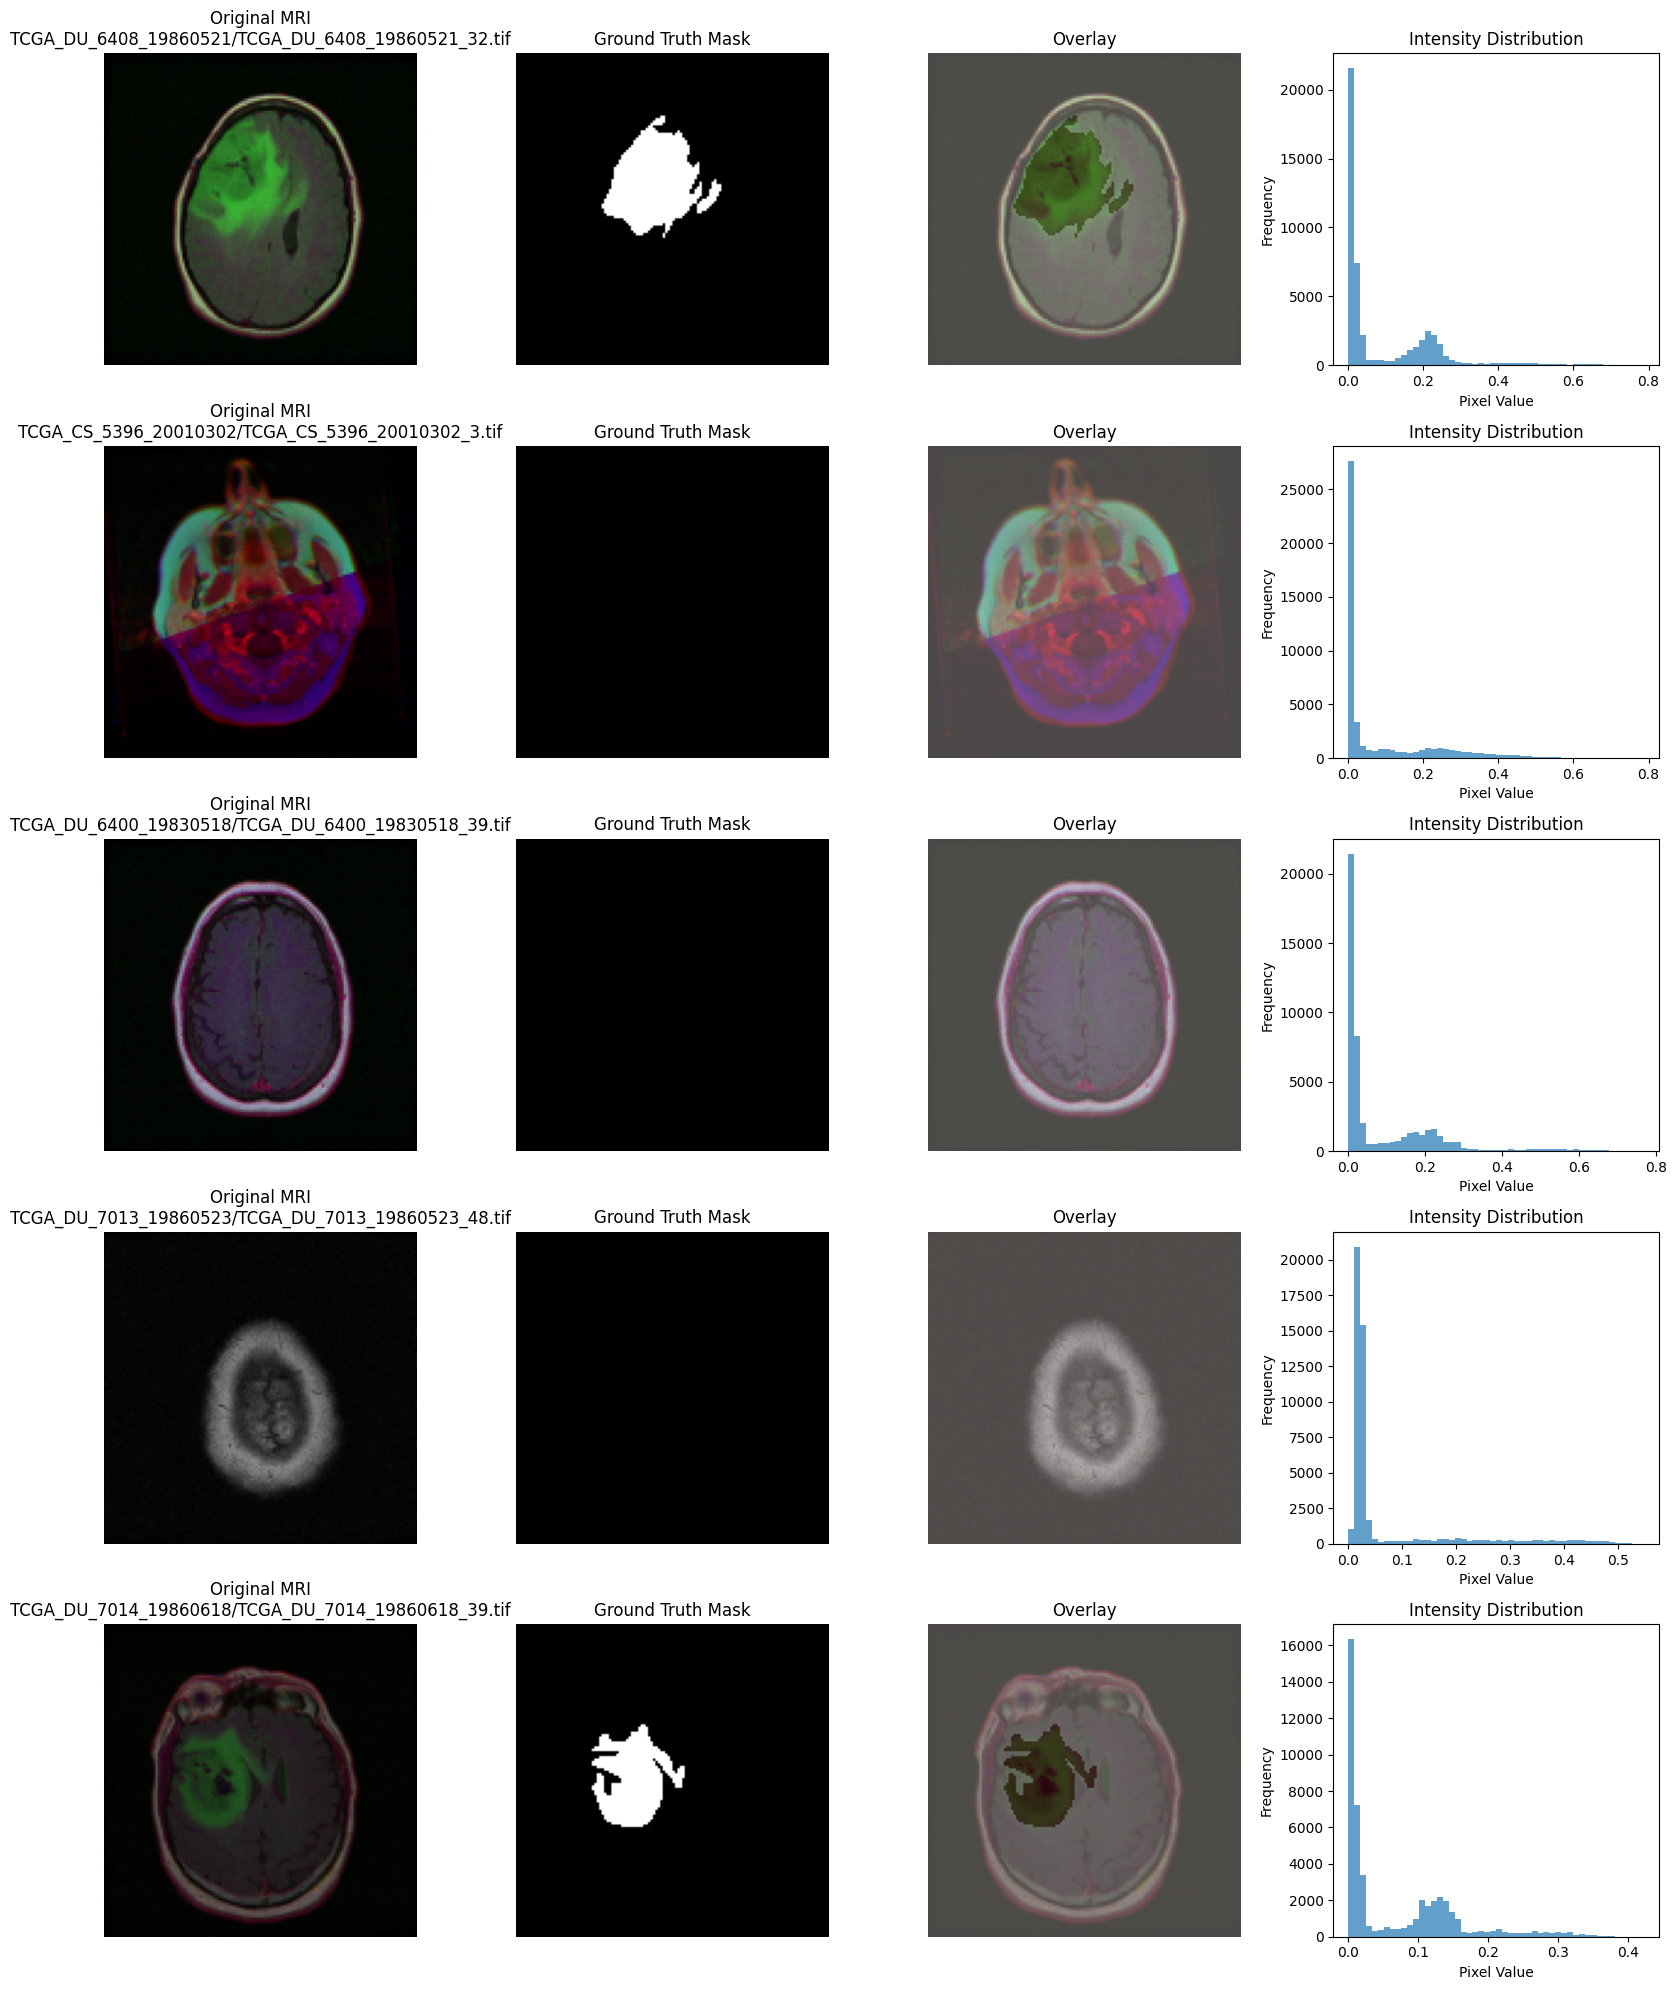

In [9]:
visualize_samples(images,masks,filenames,num_samples=5)

In [10]:
def plot_data_distribution(images, masks):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    mask_pixels = [np.sum(mask > 0.5) for mask in masks]
    axes[0].hist(mask_pixels, bins=30, alpha=0.7, color='blue')
    axes[0].set_xlabel('Tumor Area (pixels)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Tumor Size Distribution')
    axes[0].grid(True, alpha=0.3)

    mean_intensities = [np.mean(img) for img in images]
    axes[1].hist(mean_intensities, bins=30, alpha=0.7, color='green')
    axes[1].set_xlabel('Mean Intensity')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Image Intensity Distribution')
    axes[1].grid(True, alpha=0.3)

    tumor_presence = ['Tumor Present' if np.sum(mask) > 0 else 'No Tumor' for mask in masks]
    tumor_counts = pd.Series(tumor_presence).value_counts()
    axes[2].bar(tumor_counts.index, tumor_counts.values, color=['red', 'gray'])
    axes[2].set_ylabel('Count')
    axes[2].set_title('Tumor Presence Distribution')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

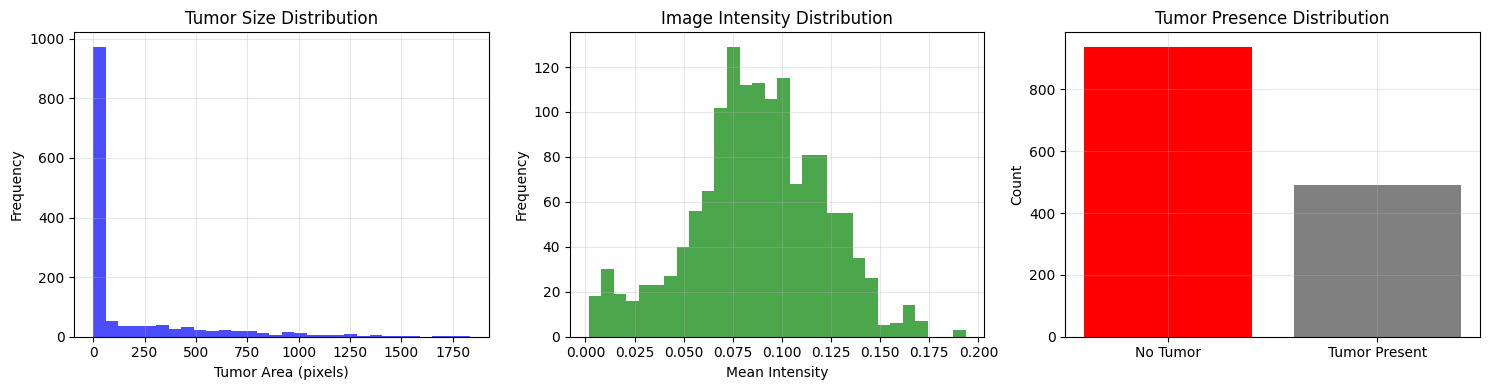

In [11]:
plot_data_distribution(images, masks)

In [12]:
def create_augmentation_pipeline():
    img_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    mask_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    return img_gen, mask_gen


In [13]:
def visualize_augmentation(images, masks, num_samples=4):
    img_gen, mask_gen = create_augmentation_pipeline()

    fig, axes = plt.subplots(num_samples, 4, figsize=(14, 4 * num_samples))
    seed = np.random.randint(1000)

    image_flow = img_gen.flow(images[:num_samples], batch_size=1, seed=seed)
    mask_flow = mask_gen.flow(masks[:num_samples], batch_size=1, seed=seed)

    for i in range(num_samples):
        aug_img = next(image_flow)[0]
        aug_mask = next(mask_flow)[0]

        # ⚠ Fix masks so they don’t blur or wash out
        aug_mask = (aug_mask > 0.4).astype('float32')

        # ⚠ Normalize for display only
        disp_img = np.clip(aug_img, 0, 1)

        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(disp_img)
        axes[i, 1].set_title("Augmented Image")
        axes[i, 1].axis('off')

        axes[i, 2].imshow(masks[i].squeeze(), cmap='gray')
        axes[i, 2].set_title("Original Mask")
        axes[i, 2].axis('off')

        axes[i, 3].imshow(aug_mask.squeeze(), cmap='gray')
        axes[i, 3].set_title("Augmented Mask")
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()


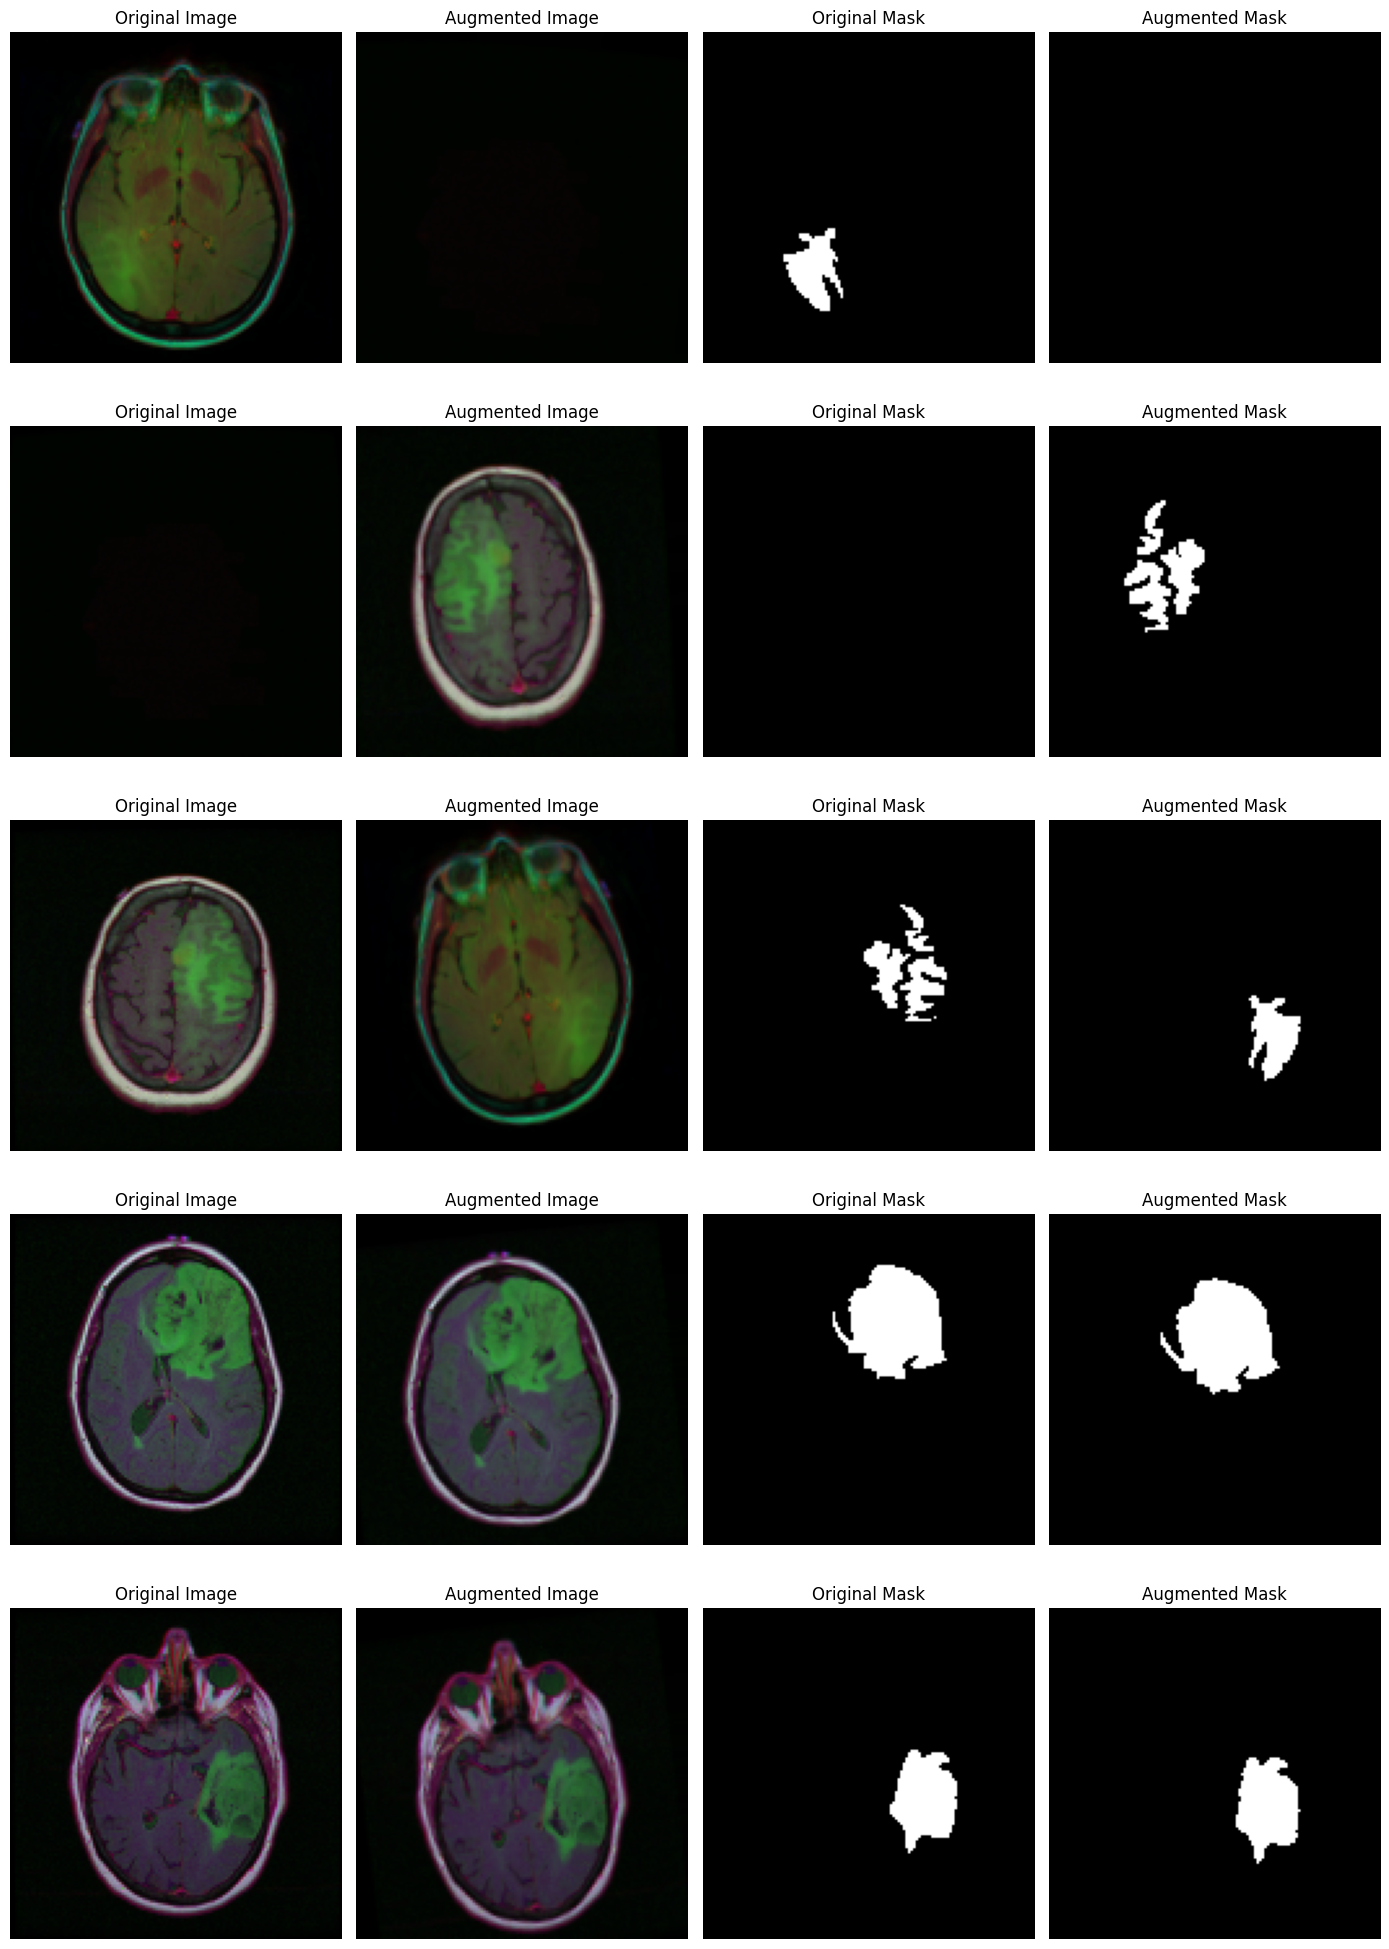

In [16]:
visualize_augmentation(X_train, y_train, num_samples=5)


In [17]:
def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    def conv_block(x, filters, kernel_size=3):
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, kernel_size, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        return x

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bridge
    c4 = conv_block(p3, 512)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = conv_block(u5, 256)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = conv_block(u6, 128)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = conv_block(u7, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model



In [18]:
uNet = build_unet(input_shape=(128, 128, 3))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 7,708,609 (29.41 MB)

 Trainable params: 7,702,977 (29.38 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [19]:
def build_resunet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    def residual_block(x, filters):
        shortcut = x

        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        if shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([x, shortcut])
        x = layers.Activation('relu')(x)

        return x

    # Initial convolution
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Encoder
    x1 = residual_block(x, 64)
    p1 = layers.MaxPooling2D((2, 2))(x1)

    x2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(x2)

    x3 = residual_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(x3)

    # Bridge
    x4 = residual_block(p3, 512)

    # Decoder
    u5 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x4)
    u5 = layers.concatenate([u5, x3])
    x5 = residual_block(u5, 256)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x5)
    u6 = layers.concatenate([u6, x2])
    x6 = residual_block(u6, 128)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x6)
    u7 = layers.concatenate([u7, x1])
    x7 = residual_block(u7, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x7)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model


In [20]:
ResUnet=build_resunet()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_14[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_15[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ activation_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ activation_16[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │    147,584 │ activation_17[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │      8,320 │ max_pooling2d_3[

 Total params: 8,096,577 (30.89 MB)

 Trainable params: 8,088,129 (30.85 MB)

 Non-trainable params: 8,448 (33.00 KB)

In [21]:
def build_deeplab_simple(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Atrous convolutions at different rates (simplified ASPP)
    rate1 = layers.Conv2D(128, 3, padding='same', dilation_rate=1)(x)
    rate1 = layers.BatchNormalization()(rate1)
    rate1 = layers.Activation('relu')(rate1)

    rate6 = layers.Conv2D(128, 3, padding='same', dilation_rate=6)(x)
    rate6 = layers.BatchNormalization()(rate6)
    rate6 = layers.Activation('relu')(rate6)

    rate12 = layers.Conv2D(128, 3, padding='same', dilation_rate=12)(x)
    rate12 = layers.BatchNormalization()(rate12)
    rate12 = layers.Activation('relu')(rate12)

    rate18 = layers.Conv2D(128, 3, padding='same', dilation_rate=18)(x)
    rate18 = layers.BatchNormalization()(rate18)
    rate18 = layers.Activation('relu')(rate18)

    # Concatenate all rates
    x = layers.concatenate([rate1, rate6, rate12, rate18])

    # Reduce channels
    x = layers.Conv2D(256, 1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Decoder
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Output
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

# Use this simpler version:
# DeepLab = build_deeplab_simple()

In [22]:
DeepLab=build_deeplab_simple()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_29[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation_30[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation_30[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation_30[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 128, 128,  │     73,856 │ activation_30[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_32       │ (None, 128, 128,  │          0 │ batch_normalizat

 Total params: 838,721 (3.20 MB)

 Trainable params: 836,545 (3.19 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [23]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice


In [24]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    """Plot Loss, Accuracy, Dice, and IoU curves"""
    metrics = ['loss', 'accuracy', 'dice_coefficient', 'iou_metric']
    titles = ['Loss', 'Accuracy', 'Dice Coefficient', 'IoU Score']

    plt.figure(figsize=(14, 10))

    for i, metric in enumerate(metrics):
        if metric in history.history:  # To avoid missing metric errors
            plt.subplot(2, 2, i+1)
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
            plt.title(f'{model_name} - {titles[i]}')
            plt.xlabel('Epochs')
            plt.ylabel(titles[i])
            plt.legend()
            plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


In [25]:
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=50, batch_size=32):
    print(f"\nTraining {model_name}...")
    print("-" * 40)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=bce_dice_loss,
        metrics=['accuracy', dice_coefficient, iou_metric]
    )

    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=f'best_{model_name}.h5',
            monitor='val_dice_coefficient',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

    # Training with data augmentation
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    plot_training_history(history, model_name)

    return model, history



Training uNet...
----------------------------------------
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.5826 - dice_coefficient: 0.0313 - iou_metric: 0.0159 - loss: 1.6909
Epoch 1: val_dice_coefficient improved from -inf to 0.02238, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 885ms/step - accuracy: 0.5883 - dice_coefficient: 0.0315 - iou_metric: 0.0160 - loss: 1.6862 - val_accuracy: 0.6125 - val_dice_coefficient: 0.0224 - val_iou_metric: 0.0113 - val_loss: 1.6715 - learning_rate: 1.0000e-04
Epoch 2/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9856 - dice_coefficient: 0.0593 - iou_metric: 0.0307 - loss: 1.2222
Epoch 2: val_dice_coefficient improved from 0.02238 to 0.02321, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - accuracy: 0.9859 - dice_coefficient: 0.0597 - iou_metric: 0.0309 - loss: 1.2196 - val_accuracy: 0.8182 - val_dice_coefficient: 0.0232 - val_iou_metric: 0.0117 - val_loss: 1.6095 - learning_rate: 1.0000e-04
Epoch 3/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9923 - dice_coefficient: 0.0855 - iou_metric: 0.0448 - loss: 1.0989
Epoch 3: val_dice_coefficient did not improve from 0.02321
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.9922 - dice_coefficient: 0.0857 - iou_metric: 0.0450 - loss: 1.0984 - val_accuracy: 0.9889 - val_dice_coefficient: 0.0232 - val_iou_metric: 0.0117 - val_loss: 1.5286 - learning_rate: 1.0000e-04
Epoch 4/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9939 - dice_coefficient: 0.0945 - iou_metric: 0.0498 - loss: 1.0620
Epoch 4: val_dice_coefficient did not improve from 0.02321
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - accuracy: 0.9939 - dice_coefficient: 0.0951 - iou_metric: 0.0502 - loss: 

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.9921 - dice_coefficient: 0.1360 - iou_metric: 0.0735 - loss: 0.9945 - val_accuracy: 0.9889 - val_dice_coefficient: 0.0236 - val_iou_metric: 0.0120 - val_loss: 1.1723 - learning_rate: 1.0000e-04
Epoch 8/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9869 - dice_coefficient: 0.1307 - iou_metric: 0.0705 - loss: 1.0231
Epoch 8: val_dice_coefficient improved from 0.02362 to 0.03418, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.9871 - dice_coefficient: 0.1308 - iou_metric: 0.0705 - loss: 1.0222 - val_accuracy: 0.9902 - val_dice_coefficient: 0.0342 - val_iou_metric: 0.0174 - val_loss: 1.1583 - learning_rate: 1.0000e-04
Epoch 9/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9939 - dice_coefficient: 0.1485 - iou_metric: 0.0806 - loss: 0.9645
Epoch 9: val_dice_coefficient did not improve from 0.03418
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9939 - dice_coefficient: 0.1489 - iou_metric: 0.0808 - loss: 0.9638 - val_accuracy: 0.9893 - val_dice_coefficient: 0.0268 - val_iou_metric: 0.0136 - val_loss: 1.1206 - learning_rate: 1.0000e-04
Epoch 10/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9948 - dice_coefficient: 0.1807 - iou_metric: 0.1004 - loss: 0.9182
Epoch 10: val_dice_coefficient did not improve from 0.03418
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.9948 - dice_coefficient: 0.1801 - iou_metric: 0.1000 - loss

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9955 - dice_coefficient: 0.1950 - iou_metric: 0.1093 - loss: 0.8963 - val_accuracy: 0.9909 - val_dice_coefficient: 0.0656 - val_iou_metric: 0.0340 - val_loss: 1.0228 - learning_rate: 1.0000e-04
Epoch 12/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9958 - dice_coefficient: 0.1913 - iou_metric: 0.1065 - loss: 0.8935
Epoch 12: val_dice_coefficient improved from 0.06559 to 0.10505, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9958 - dice_coefficient: 0.1918 - iou_metric: 0.1068 - loss: 0.8928 - val_accuracy: 0.9918 - val_dice_coefficient: 0.1050 - val_iou_metric: 0.0557 - val_loss: 0.9718 - learning_rate: 1.0000e-04
Epoch 13/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9954 - dice_coefficient: 0.2116 - iou_metric: 0.1197 - loss: 0.8693
Epoch 13: val_dice_coefficient did not improve from 0.10505
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.9955 - dice_coefficient: 0.2116 - iou_metric: 0.1198 - loss: 0.8692 - val_accuracy: 0.9913 - val_dice_coefficient: 0.0859 - val_iou_metric: 0.0451 - val_loss: 0.9921 - learning_rate: 1.0000e-04
Epoch 14/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9958 - dice_coefficient: 0.2277 - iou_metric: 0.1297 - loss: 0.8460
Epoch 14: val_dice_coefficient improved from 0.10505 to 0.17250, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.9958 - dice_coefficient: 0.2276 - iou_metric: 0.1296 - loss: 0.8463 - val_accuracy: 0.9929 - val_dice_coefficient: 0.1725 - val_iou_metric: 0.0948 - val_loss: 0.8988 - learning_rate: 1.0000e-04
Epoch 15/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9961 - dice_coefficient: 0.2299 - iou_metric: 0.1315 - loss: 0.8379
Epoch 15: val_dice_coefficient improved from 0.17250 to 0.19605, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.9961 - dice_coefficient: 0.2307 - iou_metric: 0.1320 - loss: 0.8372 - val_accuracy: 0.9942 - val_dice_coefficient: 0.1961 - val_iou_metric: 0.1091 - val_loss: 0.8707 - learning_rate: 1.0000e-04
Epoch 16/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9954 - dice_coefficient: 0.2120 - iou_metric: 0.1205 - loss: 0.8551
Epoch 16: val_dice_coefficient improved from 0.19605 to 0.20683, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.9954 - dice_coefficient: 0.2141 - iou_metric: 0.1218 - loss: 0.8528 - val_accuracy: 0.9948 - val_dice_coefficient: 0.2068 - val_iou_metric: 0.1160 - val_loss: 0.8555 - learning_rate: 1.0000e-04
Epoch 17/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9963 - dice_coefficient: 0.2646 - iou_metric: 0.1542 - loss: 0.7946
Epoch 17: val_dice_coefficient improved from 0.20683 to 0.24831, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9963 - dice_coefficient: 0.2643 - iou_metric: 0.1541 - loss: 0.7945 - val_accuracy: 0.9949 - val_dice_coefficient: 0.2483 - val_iou_metric: 0.1424 - val_loss: 0.8114 - learning_rate: 1.0000e-04
Epoch 18/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9953 - dice_coefficient: 0.2709 - iou_metric: 0.1582 - loss: 0.7911
Epoch 18: val_dice_coefficient improved from 0.24831 to 0.27984, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9953 - dice_coefficient: 0.2711 - iou_metric: 0.1584 - loss: 0.7909 - val_accuracy: 0.9944 - val_dice_coefficient: 0.2798 - val_iou_metric: 0.1634 - val_loss: 0.7859 - learning_rate: 1.0000e-04
Epoch 19/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9957 - dice_coefficient: 0.2865 - iou_metric: 0.1693 - loss: 0.7687
Epoch 19: val_dice_coefficient improved from 0.27984 to 0.29354, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9958 - dice_coefficient: 0.2866 - iou_metric: 0.1694 - loss: 0.7683 - val_accuracy: 0.9964 - val_dice_coefficient: 0.2935 - val_iou_metric: 0.1728 - val_loss: 0.7558 - learning_rate: 1.0000e-04
Epoch 20/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9966 - dice_coefficient: 0.2866 - iou_metric: 0.1690 - loss: 0.7629
Epoch 20: val_dice_coefficient improved from 0.29354 to 0.32162, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9966 - dice_coefficient: 0.2883 - iou_metric: 0.1702 - loss: 0.7613 - val_accuracy: 0.9963 - val_dice_coefficient: 0.3216 - val_iou_metric: 0.1926 - val_loss: 0.7252 - learning_rate: 1.0000e-04
Epoch 21/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9965 - dice_coefficient: 0.3333 - iou_metric: 0.2019 - loss: 0.7133
Epoch 21: val_dice_coefficient improved from 0.32162 to 0.33770, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9965 - dice_coefficient: 0.3334 - iou_metric: 0.2021 - loss: 0.7132 - val_accuracy: 0.9967 - val_dice_coefficient: 0.3377 - val_iou_metric: 0.2041 - val_loss: 0.7044 - learning_rate: 1.0000e-04
Epoch 22/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9970 - dice_coefficient: 0.3495 - iou_metric: 0.2139 - loss: 0.6910
Epoch 22: val_dice_coefficient improved from 0.33770 to 0.36477, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.9970 - dice_coefficient: 0.3494 - iou_metric: 0.2139 - loss: 0.6909 - val_accuracy: 0.9970 - val_dice_coefficient: 0.3648 - val_iou_metric: 0.2242 - val_loss: 0.6714 - learning_rate: 1.0000e-04
Epoch 23/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9972 - dice_coefficient: 0.3611 - iou_metric: 0.2249 - loss: 0.6766
Epoch 23: val_dice_coefficient improved from 0.36477 to 0.38222, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9972 - dice_coefficient: 0.3617 - iou_metric: 0.2253 - loss: 0.6762 - val_accuracy: 0.9965 - val_dice_coefficient: 0.3822 - val_iou_metric: 0.2375 - val_loss: 0.6546 - learning_rate: 1.0000e-04
Epoch 24/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9971 - dice_coefficient: 0.3943 - iou_metric: 0.2487 - loss: 0.6412
Epoch 24: val_dice_coefficient improved from 0.38222 to 0.39798, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.9971 - dice_coefficient: 0.3940 - iou_metric: 0.2486 - loss: 0.6416 - val_accuracy: 0.9967 - val_dice_coefficient: 0.3980 - val_iou_metric: 0.2499 - val_loss: 0.6363 - learning_rate: 1.0000e-04
Epoch 25/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9969 - dice_coefficient: 0.4061 - iou_metric: 0.2574 - loss: 0.6283
Epoch 25: val_dice_coefficient improved from 0.39798 to 0.41178, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.9969 - dice_coefficient: 0.4062 - iou_metric: 0.2575 - loss: 0.6283 - val_accuracy: 0.9953 - val_dice_coefficient: 0.4118 - val_iou_metric: 0.2607 - val_loss: 0.6301 - learning_rate: 1.0000e-04
Epoch 26/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9972 - dice_coefficient: 0.4275 - iou_metric: 0.2740 - loss: 0.6055
Epoch 26: val_dice_coefficient did not improve from 0.41178
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.9972 - dice_coefficient: 0.4269 - iou_metric: 0.2738 - loss: 0.6055 - val_accuracy: 0.9875 - val_dice_coefficient: 0.3782 - val_iou_metric: 0.2349 - val_loss: 0.6859 - learning_rate: 1.0000e-04
Epoch 27/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9965 - dice_coefficient: 0.4256 - iou_metric: 0.2740 - loss: 0.6095
Epoch 27: val_dice_coefficient improved from 0.41178 to 0.43842, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.9965 - dice_coefficient: 0.4261 - iou_metric: 0.2745 - loss: 0.6093 - val_accuracy: 0.9967 - val_dice_coefficient: 0.4384 - val_iou_metric: 0.2820 - val_loss: 0.5925 - learning_rate: 1.0000e-04
Epoch 28/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9973 - dice_coefficient: 0.4353 - iou_metric: 0.2816 - loss: 0.5931
Epoch 28: val_dice_coefficient improved from 0.43842 to 0.46130, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9973 - dice_coefficient: 0.4367 - iou_metric: 0.2828 - loss: 0.5915 - val_accuracy: 0.9968 - val_dice_coefficient: 0.4613 - val_iou_metric: 0.3012 - val_loss: 0.5698 - learning_rate: 1.0000e-04
Epoch 29/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9976 - dice_coefficient: 0.4865 - iou_metric: 0.3242 - loss: 0.5387
Epoch 29: val_dice_coefficient improved from 0.46130 to 0.48925, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9976 - dice_coefficient: 0.4859 - iou_metric: 0.3239 - loss: 0.5389 - val_accuracy: 0.9971 - val_dice_coefficient: 0.4892 - val_iou_metric: 0.3254 - val_loss: 0.5350 - learning_rate: 1.0000e-04
Epoch 30/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9975 - dice_coefficient: 0.4953 - iou_metric: 0.3348 - loss: 0.5293
Epoch 30: val_dice_coefficient improved from 0.48925 to 0.49969, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9975 - dice_coefficient: 0.4955 - iou_metric: 0.3349 - loss: 0.5289 - val_accuracy: 0.9969 - val_dice_coefficient: 0.4997 - val_iou_metric: 0.3348 - val_loss: 0.5232 - learning_rate: 1.0000e-04
Epoch 31/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9977 - dice_coefficient: 0.5216 - iou_metric: 0.3611 - loss: 0.5002
Epoch 31: val_dice_coefficient improved from 0.49969 to 0.52080, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9977 - dice_coefficient: 0.5208 - iou_metric: 0.3604 - loss: 0.5005 - val_accuracy: 0.9970 - val_dice_coefficient: 0.5208 - val_iou_metric: 0.3535 - val_loss: 0.5009 - learning_rate: 1.0000e-04
Epoch 32/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9977 - dice_coefficient: 0.5342 - iou_metric: 0.3698 - loss: 0.4868
Epoch 32: val_dice_coefficient improved from 0.52080 to 0.55022, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9977 - dice_coefficient: 0.5344 - iou_metric: 0.3701 - loss: 0.4866 - val_accuracy: 0.9959 - val_dice_coefficient: 0.5502 - val_iou_metric: 0.3814 - val_loss: 0.4781 - learning_rate: 1.0000e-04
Epoch 33/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9972 - dice_coefficient: 0.5614 - iou_metric: 0.3941 - loss: 0.4637
Epoch 33: val_dice_coefficient improved from 0.55022 to 0.57023, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9972 - dice_coefficient: 0.5615 - iou_metric: 0.3942 - loss: 0.4633 - val_accuracy: 0.9971 - val_dice_coefficient: 0.5702 - val_iou_metric: 0.4007 - val_loss: 0.4500 - learning_rate: 1.0000e-04
Epoch 34/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9976 - dice_coefficient: 0.5948 - iou_metric: 0.4275 - loss: 0.4241
Epoch 34: val_dice_coefficient improved from 0.57023 to 0.58766, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9976 - dice_coefficient: 0.5937 - iou_metric: 0.4266 - loss: 0.4247 - val_accuracy: 0.9972 - val_dice_coefficient: 0.5877 - val_iou_metric: 0.4179 - val_loss: 0.4311 - learning_rate: 1.0000e-04
Epoch 35/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9979 - dice_coefficient: 0.6059 - iou_metric: 0.4392 - loss: 0.4112
Epoch 35: val_dice_coefficient improved from 0.58766 to 0.60327, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9979 - dice_coefficient: 0.6057 - iou_metric: 0.4390 - loss: 0.4115 - val_accuracy: 0.9972 - val_dice_coefficient: 0.6033 - val_iou_metric: 0.4335 - val_loss: 0.4140 - learning_rate: 1.0000e-04
Epoch 36/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9980 - dice_coefficient: 0.6297 - iou_metric: 0.4627 - loss: 0.3861
Epoch 36: val_dice_coefficient improved from 0.60327 to 0.61257, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9980 - dice_coefficient: 0.6293 - iou_metric: 0.4625 - loss: 0.3868 - val_accuracy: 0.9966 - val_dice_coefficient: 0.6126 - val_iou_metric: 0.4436 - val_loss: 0.4109 - learning_rate: 1.0000e-04
Epoch 37/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9980 - dice_coefficient: 0.6437 - iou_metric: 0.4781 - loss: 0.3725
Epoch 37: val_dice_coefficient improved from 0.61257 to 0.62841, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9980 - dice_coefficient: 0.6440 - iou_metric: 0.4784 - loss: 0.3722 - val_accuracy: 0.9971 - val_dice_coefficient: 0.6284 - val_iou_metric: 0.4599 - val_loss: 0.3891 - learning_rate: 1.0000e-04
Epoch 38/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9981 - dice_coefficient: 0.6817 - iou_metric: 0.5209 - loss: 0.3325
Epoch 38: val_dice_coefficient improved from 0.62841 to 0.65466, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9981 - dice_coefficient: 0.6806 - iou_metric: 0.5198 - loss: 0.3338 - val_accuracy: 0.9973 - val_dice_coefficient: 0.6547 - val_iou_metric: 0.4884 - val_loss: 0.3613 - learning_rate: 1.0000e-04
Epoch 39/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9981 - dice_coefficient: 0.6778 - iou_metric: 0.5192 - loss: 0.3359
Epoch 39: val_dice_coefficient improved from 0.65466 to 0.66136, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9981 - dice_coefficient: 0.6771 - iou_metric: 0.5185 - loss: 0.3367 - val_accuracy: 0.9973 - val_dice_coefficient: 0.6614 - val_iou_metric: 0.4957 - val_loss: 0.3540 - learning_rate: 1.0000e-04
Epoch 40/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9984 - dice_coefficient: 0.6853 - iou_metric: 0.5226 - loss: 0.3275
Epoch 40: val_dice_coefficient improved from 0.66136 to 0.67849, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9984 - dice_coefficient: 0.6861 - iou_metric: 0.5236 - loss: 0.3267 - val_accuracy: 0.9971 - val_dice_coefficient: 0.6785 - val_iou_metric: 0.5152 - val_loss: 0.3385 - learning_rate: 1.0000e-04
Epoch 41/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9983 - dice_coefficient: 0.6866 - iou_metric: 0.5341 - loss: 0.3258
Epoch 41: val_dice_coefficient did not improve from 0.67849
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - accuracy: 0.9983 - dice_coefficient: 0.6868 - iou_metric: 0.5342 - loss: 0.3257 - val_accuracy: 0.9967 - val_dice_coefficient: 0.6784 - val_iou_metric: 0.5148 - val_loss: 0.3462 - learning_rate: 1.0000e-04
Epoch 42/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9982 - dice_coefficient: 0.7015 - iou_metric: 0.5460 - loss: 0.3113
Epoch 42: val_dice_coefficient improved from 0.67849 to 0.70396, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9982 - dice_coefficient: 0.7024 - iou_metric: 0.5469 - loss: 0.3103 - val_accuracy: 0.9973 - val_dice_coefficient: 0.7040 - val_iou_metric: 0.5449 - val_loss: 0.3103 - learning_rate: 1.0000e-04
Epoch 43/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9984 - dice_coefficient: 0.7272 - iou_metric: 0.5735 - loss: 0.2834
Epoch 43: val_dice_coefficient did not improve from 0.70396
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.9984 - dice_coefficient: 0.7279 - iou_metric: 0.5744 - loss: 0.2827 - val_accuracy: 0.9973 - val_dice_coefficient: 0.7034 - val_iou_metric: 0.5439 - val_loss: 0.3099 - learning_rate: 1.0000e-04
Epoch 44/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9985 - dice_coefficient: 0.7413 - iou_metric: 0.5918 - loss: 0.2686
Epoch 44: val_dice_coefficient improved from 0.70396 to 0.70910, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9985 - dice_coefficient: 0.7413 - iou_metric: 0.5919 - loss: 0.2684 - val_accuracy: 0.9968 - val_dice_coefficient: 0.7091 - val_iou_metric: 0.5509 - val_loss: 0.3079 - learning_rate: 1.0000e-04
Epoch 45/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9985 - dice_coefficient: 0.7536 - iou_metric: 0.6074 - loss: 0.2561
Epoch 45: val_dice_coefficient improved from 0.70910 to 0.72582, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9985 - dice_coefficient: 0.7539 - iou_metric: 0.6079 - loss: 0.2557 - val_accuracy: 0.9972 - val_dice_coefficient: 0.7258 - val_iou_metric: 0.5711 - val_loss: 0.2879 - learning_rate: 1.0000e-04
Epoch 46/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9985 - dice_coefficient: 0.7751 - iou_metric: 0.6352 - loss: 0.2340
Epoch 46: val_dice_coefficient improved from 0.72582 to 0.72856, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9985 - dice_coefficient: 0.7745 - iou_metric: 0.6346 - loss: 0.2342 - val_accuracy: 0.9974 - val_dice_coefficient: 0.7286 - val_iou_metric: 0.5747 - val_loss: 0.2839 - learning_rate: 1.0000e-04
Epoch 47/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9983 - dice_coefficient: 0.7499 - iou_metric: 0.6069 - loss: 0.2616
Epoch 47: val_dice_coefficient did not improve from 0.72856
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - accuracy: 0.9983 - dice_coefficient: 0.7498 - iou_metric: 0.6068 - loss: 0.2617 - val_accuracy: 0.9957 - val_dice_coefficient: 0.6837 - val_iou_metric: 0.5204 - val_loss: 0.3394 - learning_rate: 1.0000e-04
Epoch 48/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9982 - dice_coefficient: 0.7650 - iou_metric: 0.6225 - loss: 0.2458
Epoch 48: val_dice_coefficient improved from 0.72856 to 0.75789, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9982 - dice_coefficient: 0.7651 - iou_metric: 0.6227 - loss: 0.2456 - val_accuracy: 0.9972 - val_dice_coefficient: 0.7579 - val_iou_metric: 0.6114 - val_loss: 0.2625 - learning_rate: 1.0000e-04
Epoch 49/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9981 - dice_coefficient: 0.7795 - iou_metric: 0.6435 - loss: 0.2318
Epoch 49: val_dice_coefficient did not improve from 0.75789
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.9981 - dice_coefficient: 0.7794 - iou_metric: 0.6431 - loss: 0.2318 - val_accuracy: 0.9973 - val_dice_coefficient: 0.7562 - val_iou_metric: 0.6094 - val_loss: 0.2570 - learning_rate: 1.0000e-04
Epoch 50/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9983 - dice_coefficient: 0.7807 - iou_metric: 0.6431 - loss: 0.2291
Epoch 50: val_dice_coefficient improved from 0.75789 to 0.75930, saving model to best_uNet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.9983 - dice_coefficient: 0.7801 - iou_metric: 0.6425 - loss: 0.2291 - val_accuracy: 0.9972 - val_dice_coefficient: 0.7593 - val_iou_metric: 0.6133 - val_loss: 0.2636 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 49.


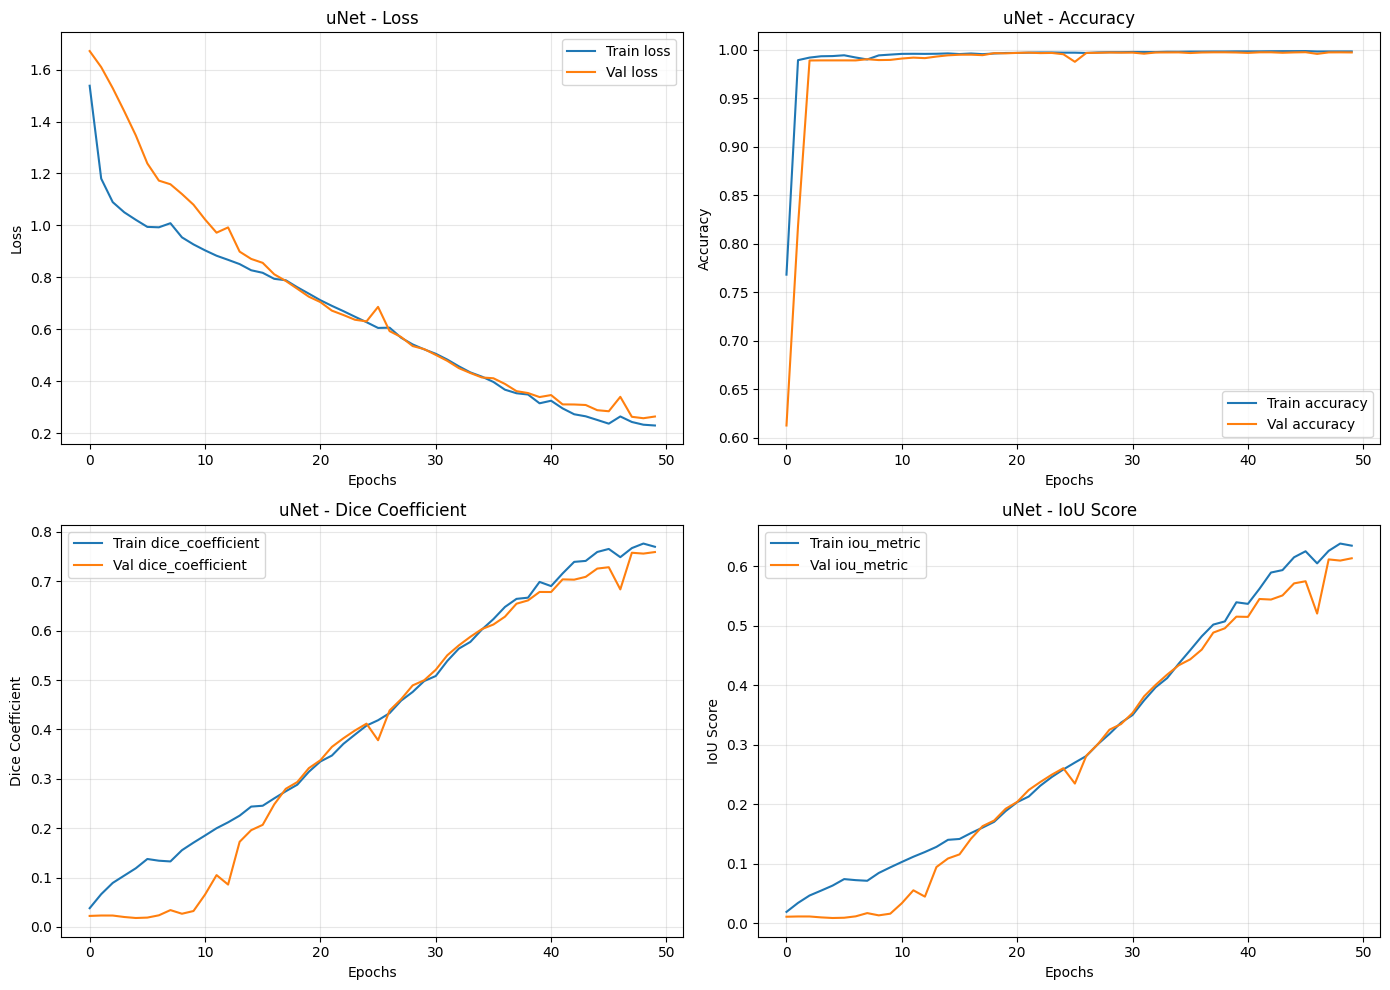

(<Functional name=functional, built=True>,
 <keras.src.callbacks.history.History at 0x786928ead1f0>)

In [27]:
train_model(uNet, X_train, y_train, X_val, y_val, model_name='uNet', epochs=50, batch_size=32)



Training ResUnet...
----------------------------------------
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.8990 - dice_coefficient: 0.0584 - iou_metric: 0.0307 - loss: 1.2759
Epoch 1: val_dice_coefficient improved from -inf to 0.02509, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 795ms/step - accuracy: 0.9007 - dice_coefficient: 0.0597 - iou_metric: 0.0315 - loss: 1.2705 - val_accuracy: 0.9881 - val_dice_coefficient: 0.0251 - val_iou_metric: 0.0127 - val_loss: 1.4335 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9884 - dice_coefficient: 0.2483 - iou_metric: 0.1448 - loss: 0.8077
Epoch 2: val_dice_coefficient improved from 0.02509 to 0.02916, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.9885 - dice_coefficient: 0.2502 - iou_metric: 0.1462 - loss: 0.8056 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0292 - val_iou_metric: 0.0148 - val_loss: 1.2229 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9936 - dice_coefficient: 0.4218 - iou_metric: 0.2742 - loss: 0.6100
Epoch 3: val_dice_coefficient improved from 0.02916 to 0.03086, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step - accuracy: 0.9936 - dice_coefficient: 0.4227 - iou_metric: 0.2749 - loss: 0.6091 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0309 - val_iou_metric: 0.0157 - val_loss: 1.1199 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9947 - dice_coefficient: 0.5392 - iou_metric: 0.3752 - loss: 0.4844
Epoch 4: val_dice_coefficient did not improve from 0.03086
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - accuracy: 0.9947 - dice_coefficient: 0.5399 - iou_metric: 0.3758 - loss: 0.4836 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0196 - val_iou_metric: 0.0099 - val_loss: 1.0683 - learning_rate: 1.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9955 - dice_coefficient: 0.6518 - iou_metric: 0.4891 - loss: 0.3685
Epoch 5: val_dice_coefficient did not improve from 0.03086
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 243ms/step - accuracy: 0.9955 - dice_coefficient: 0.6513 - iou_metric: 0.4885 - loss: 

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.9972 - dice_coefficient: 0.7885 - iou_metric: 0.6527 - loss: 0.2239 - val_accuracy: 0.9894 - val_dice_coefficient: 0.0578 - val_iou_metric: 0.0304 - val_loss: 1.0099 - learning_rate: 1.0000e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9975 - dice_coefficient: 0.8020 - iou_metric: 0.6716 - loss: 0.2093
Epoch 11: val_dice_coefficient improved from 0.05778 to 0.14514, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.9975 - dice_coefficient: 0.8019 - iou_metric: 0.6715 - loss: 0.2094 - val_accuracy: 0.9899 - val_dice_coefficient: 0.1451 - val_iou_metric: 0.0799 - val_loss: 0.9195 - learning_rate: 1.0000e-04
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9973 - dice_coefficient: 0.8102 - iou_metric: 0.6827 - loss: 0.2021
Epoch 12: val_dice_coefficient improved from 0.14514 to 0.24868, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 250ms/step - accuracy: 0.9973 - dice_coefficient: 0.8104 - iou_metric: 0.6829 - loss: 0.2019 - val_accuracy: 0.9906 - val_dice_coefficient: 0.2487 - val_iou_metric: 0.1447 - val_loss: 0.8057 - learning_rate: 1.0000e-04
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9979 - dice_coefficient: 0.8331 - iou_metric: 0.7152 - loss: 0.1768
Epoch 13: val_dice_coefficient improved from 0.24868 to 0.35259, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9979 - dice_coefficient: 0.8332 - iou_metric: 0.7153 - loss: 0.1768 - val_accuracy: 0.9913 - val_dice_coefficient: 0.3526 - val_iou_metric: 0.2178 - val_loss: 0.6943 - learning_rate: 1.0000e-04
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9979 - dice_coefficient: 0.8350 - iou_metric: 0.7192 - loss: 0.1743
Epoch 14: val_dice_coefficient improved from 0.35259 to 0.42828, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.9979 - dice_coefficient: 0.8351 - iou_metric: 0.7194 - loss: 0.1741 - val_accuracy: 0.9920 - val_dice_coefficient: 0.4283 - val_iou_metric: 0.2747 - val_loss: 0.6142 - learning_rate: 1.0000e-04
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9980 - dice_coefficient: 0.8566 - iou_metric: 0.7502 - loss: 0.1518
Epoch 15: val_dice_coefficient improved from 0.42828 to 0.55238, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.9980 - dice_coefficient: 0.8563 - iou_metric: 0.7498 - loss: 0.1519 - val_accuracy: 0.9932 - val_dice_coefficient: 0.5524 - val_iou_metric: 0.3833 - val_loss: 0.4812 - learning_rate: 1.0000e-04
Epoch 16/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9977 - dice_coefficient: 0.8421 - iou_metric: 0.7295 - loss: 0.1675
Epoch 16: val_dice_coefficient did not improve from 0.55238
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.9977 - dice_coefficient: 0.8411 - iou_metric: 0.7286 - loss: 0.1678 - val_accuracy: 0.9930 - val_dice_coefficient: 0.5333 - val_iou_metric: 0.3661 - val_loss: 0.5051 - learning_rate: 1.0000e-04
Epoch 17/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9978 - dice_coefficient: 0.8508 - iou_metric: 0.7418 - loss: 0.1586
Epoch 17: val_dice_coefficient improved from 0.55238 to 0.71450, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 256ms/step - accuracy: 0.9978 - dice_coefficient: 0.8509 - iou_metric: 0.7419 - loss: 0.1585 - val_accuracy: 0.9953 - val_dice_coefficient: 0.7145 - val_iou_metric: 0.5582 - val_loss: 0.3067 - learning_rate: 1.0000e-04
Epoch 18/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9980 - dice_coefficient: 0.8636 - iou_metric: 0.7615 - loss: 0.1454
Epoch 18: val_dice_coefficient improved from 0.71450 to 0.73159, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.9980 - dice_coefficient: 0.8634 - iou_metric: 0.7612 - loss: 0.1456 - val_accuracy: 0.9955 - val_dice_coefficient: 0.7316 - val_iou_metric: 0.5782 - val_loss: 0.2899 - learning_rate: 1.0000e-04
Epoch 19/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9979 - dice_coefficient: 0.8669 - iou_metric: 0.7669 - loss: 0.1420
Epoch 19: val_dice_coefficient did not improve from 0.73159
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.9979 - dice_coefficient: 0.8665 - iou_metric: 0.7663 - loss: 0.1423 - val_accuracy: 0.9954 - val_dice_coefficient: 0.7057 - val_iou_metric: 0.5528 - val_loss: 0.3180 - learning_rate: 1.0000e-04
Epoch 20/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9977 - dice_coefficient: 0.8487 - iou_metric: 0.7380 - loss: 0.1618
Epoch 20: val_dice_coefficient improved from 0.73159 to 0.81443, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.9977 - dice_coefficient: 0.8488 - iou_metric: 0.7382 - loss: 0.1617 - val_accuracy: 0.9967 - val_dice_coefficient: 0.8144 - val_iou_metric: 0.6890 - val_loss: 0.2001 - learning_rate: 1.0000e-04
Epoch 21/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9980 - dice_coefficient: 0.8585 - iou_metric: 0.7546 - loss: 0.1508
Epoch 21: val_dice_coefficient did not improve from 0.81443
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.9980 - dice_coefficient: 0.8588 - iou_metric: 0.7550 - loss: 0.1505 - val_accuracy: 0.9966 - val_dice_coefficient: 0.8080 - val_iou_metric: 0.6785 - val_loss: 0.2082 - learning_rate: 1.0000e-04
Epoch 22/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9984 - dice_coefficient: 0.8839 - iou_metric: 0.7926 - loss: 0.1234
Epoch 22: val_dice_coefficient improved from 0.81443 to 0.84417, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.9984 - dice_coefficient: 0.8840 - iou_metric: 0.7927 - loss: 0.1233 - val_accuracy: 0.9972 - val_dice_coefficient: 0.8442 - val_iou_metric: 0.7311 - val_loss: 0.1675 - learning_rate: 1.0000e-04
Epoch 23/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9985 - dice_coefficient: 0.8933 - iou_metric: 0.8078 - loss: 0.1132
Epoch 23: val_dice_coefficient improved from 0.84417 to 0.85536, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9985 - dice_coefficient: 0.8934 - iou_metric: 0.8079 - loss: 0.1131 - val_accuracy: 0.9973 - val_dice_coefficient: 0.8554 - val_iou_metric: 0.7481 - val_loss: 0.1559 - learning_rate: 1.0000e-04
Epoch 24/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9986 - dice_coefficient: 0.9058 - iou_metric: 0.8284 - loss: 0.1000
Epoch 24: val_dice_coefficient improved from 0.85536 to 0.86075, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9986 - dice_coefficient: 0.9057 - iou_metric: 0.8283 - loss: 0.1002 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8607 - val_iou_metric: 0.7565 - val_loss: 0.1500 - learning_rate: 1.0000e-04
Epoch 25/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9986 - dice_coefficient: 0.9059 - iou_metric: 0.8289 - loss: 0.1003
Epoch 25: val_dice_coefficient improved from 0.86075 to 0.86202, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9986 - dice_coefficient: 0.9056 - iou_metric: 0.8286 - loss: 0.1003 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8620 - val_iou_metric: 0.7584 - val_loss: 0.1486 - learning_rate: 1.0000e-04
Epoch 26/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9986 - dice_coefficient: 0.9047 - iou_metric: 0.8266 - loss: 0.1015
Epoch 26: val_dice_coefficient did not improve from 0.86202
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.9986 - dice_coefficient: 0.9048 - iou_metric: 0.8269 - loss: 0.1013 - val_accuracy: 0.9974 - val_dice_coefficient: 0.8595 - val_iou_metric: 0.7547 - val_loss: 0.1509 - learning_rate: 1.0000e-04
Epoch 27/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9986 - dice_coefficient: 0.9109 - iou_metric: 0.8369 - loss: 0.0951
Epoch 27: val_dice_coefficient did not improve from 0.86202
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.9986 - dice_coefficient: 0.9110 - iou_metric: 0.8370 - lo

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.9987 - dice_coefficient: 0.9039 - iou_metric: 0.8260 - loss: 0.1022 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8704 - val_iou_metric: 0.7714 - val_loss: 0.1401 - learning_rate: 1.0000e-04
Epoch 30/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9988 - dice_coefficient: 0.9110 - iou_metric: 0.8380 - loss: 0.0935
Epoch 30: val_dice_coefficient did not improve from 0.87037
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.9988 - dice_coefficient: 0.9103 - iou_metric: 0.8375 - loss: 0.0936 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8628 - val_iou_metric: 0.7598 - val_loss: 0.1472 - learning_rate: 1.0000e-04
Epoch 31/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9989 - dice_coefficient: 0.9223 - iou_metric: 0.8564 - loss: 0.0823
Epoch 31: val_dice_coefficient did not improve from 0.87037
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.9989 - dice_coefficient: 0.9223 - iou_metric: 0.8564 - lo

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.9989 - dice_coefficient: 0.9301 - iou_metric: 0.8699 - loss: 0.0748 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8717 - val_iou_metric: 0.7734 - val_loss: 0.1392 - learning_rate: 1.0000e-04
Epoch 34/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9991 - dice_coefficient: 0.9369 - iou_metric: 0.8816 - loss: 0.0667
Epoch 34: val_dice_coefficient did not improve from 0.87166
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.9991 - dice_coefficient: 0.9366 - iou_metric: 0.8811 - loss: 0.0669 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8666 - val_iou_metric: 0.7655 - val_loss: 0.1444 - learning_rate: 1.0000e-04
Epoch 35/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9990 - dice_coefficient: 0.9403 - iou_metric: 0.8876 - loss: 0.0636
Epoch 35: val_dice_coefficient did not improve from 0.87166
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.9990 - dice_coefficient: 0.9402 - iou_metric: 0.8874 - lo

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.9992 - dice_coefficient: 0.9442 - iou_metric: 0.8946 - loss: 0.0594 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8725 - val_iou_metric: 0.7747 - val_loss: 0.1387 - learning_rate: 1.0000e-04
Epoch 37/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9991 - dice_coefficient: 0.9413 - iou_metric: 0.8896 - loss: 0.0628
Epoch 37: val_dice_coefficient improved from 0.87245 to 0.87295, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9991 - dice_coefficient: 0.9412 - iou_metric: 0.8894 - loss: 0.0629 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8729 - val_iou_metric: 0.7755 - val_loss: 0.1386 - learning_rate: 1.0000e-04
Epoch 38/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9991 - dice_coefficient: 0.9428 - iou_metric: 0.8920 - loss: 0.0610
Epoch 38: val_dice_coefficient improved from 0.87295 to 0.87352, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.9991 - dice_coefficient: 0.9427 - iou_metric: 0.8920 - loss: 0.0610 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8735 - val_iou_metric: 0.7765 - val_loss: 0.1376 - learning_rate: 1.0000e-04
Epoch 39/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9992 - dice_coefficient: 0.9401 - iou_metric: 0.8875 - loss: 0.0633
Epoch 39: val_dice_coefficient did not improve from 0.87352
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.9992 - dice_coefficient: 0.9401 - iou_metric: 0.8875 - loss: 0.0633 - val_accuracy: 0.9973 - val_dice_coefficient: 0.8650 - val_iou_metric: 0.7631 - val_loss: 0.1479 - learning_rate: 1.0000e-04
Epoch 40/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9993 - dice_coefficient: 0.9516 - iou_metric: 0.9077 - loss: 0.0516
Epoch 40: val_dice_coefficient improved from 0.87352 to 0.87635, saving model to best_ResUnet.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.9993 - dice_coefficient: 0.9515 - iou_metric: 0.9076 - loss: 0.0517 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8763 - val_iou_metric: 0.7806 - val_loss: 0.1359 - learning_rate: 1.0000e-04
Epoch 41/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9993 - dice_coefficient: 0.9532 - iou_metric: 0.9109 - loss: 0.0498
Epoch 41: val_dice_coefficient did not improve from 0.87635
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.9993 - dice_coefficient: 0.9530 - iou_metric: 0.9106 - loss: 0.0499 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8730 - val_iou_metric: 0.7757 - val_loss: 0.1390 - learning_rate: 1.0000e-04
Epoch 42/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9992 - dice_coefficient: 0.9497 - iou_metric: 0.9045 - loss: 0.0538
Epoch 42: val_dice_coefficient did not improve from 0.87635
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.9992 - dice_coefficient: 0.9497 - iou_metric: 0.9045 - lo

32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.9996 - dice_coefficient: 0.9639 - iou_metric: 0.9305 - loss: 0.0382 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8765 - val_iou_metric: 0.7812 - val_loss: 0.1359 - learning_rate: 5.0000e-05
Epoch 48/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9996 - dice_coefficient: 0.9654 - iou_metric: 0.9333 - loss: 0.0366
Epoch 48: val_dice_coefficient did not improve from 0.87649
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.9996 - dice_coefficient: 0.9655 - iou_metric: 0.9334 - loss: 0.0366 - val_accuracy: 0.9975 - val_dice_coefficient: 0.8734 - val_iou_metric: 0.7765 - val_loss: 0.1397 - learning_rate: 5.0000e-05
Epoch 49/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9995 - dice_coefficient: 0.9612 - iou_metric: 0.9256 - loss: 0.0410
Epoch 49: val_dice_coefficient did not improve from 0.87649
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.9995 - dice_coefficient: 0.9613 - iou_metric: 0.9258 - lo

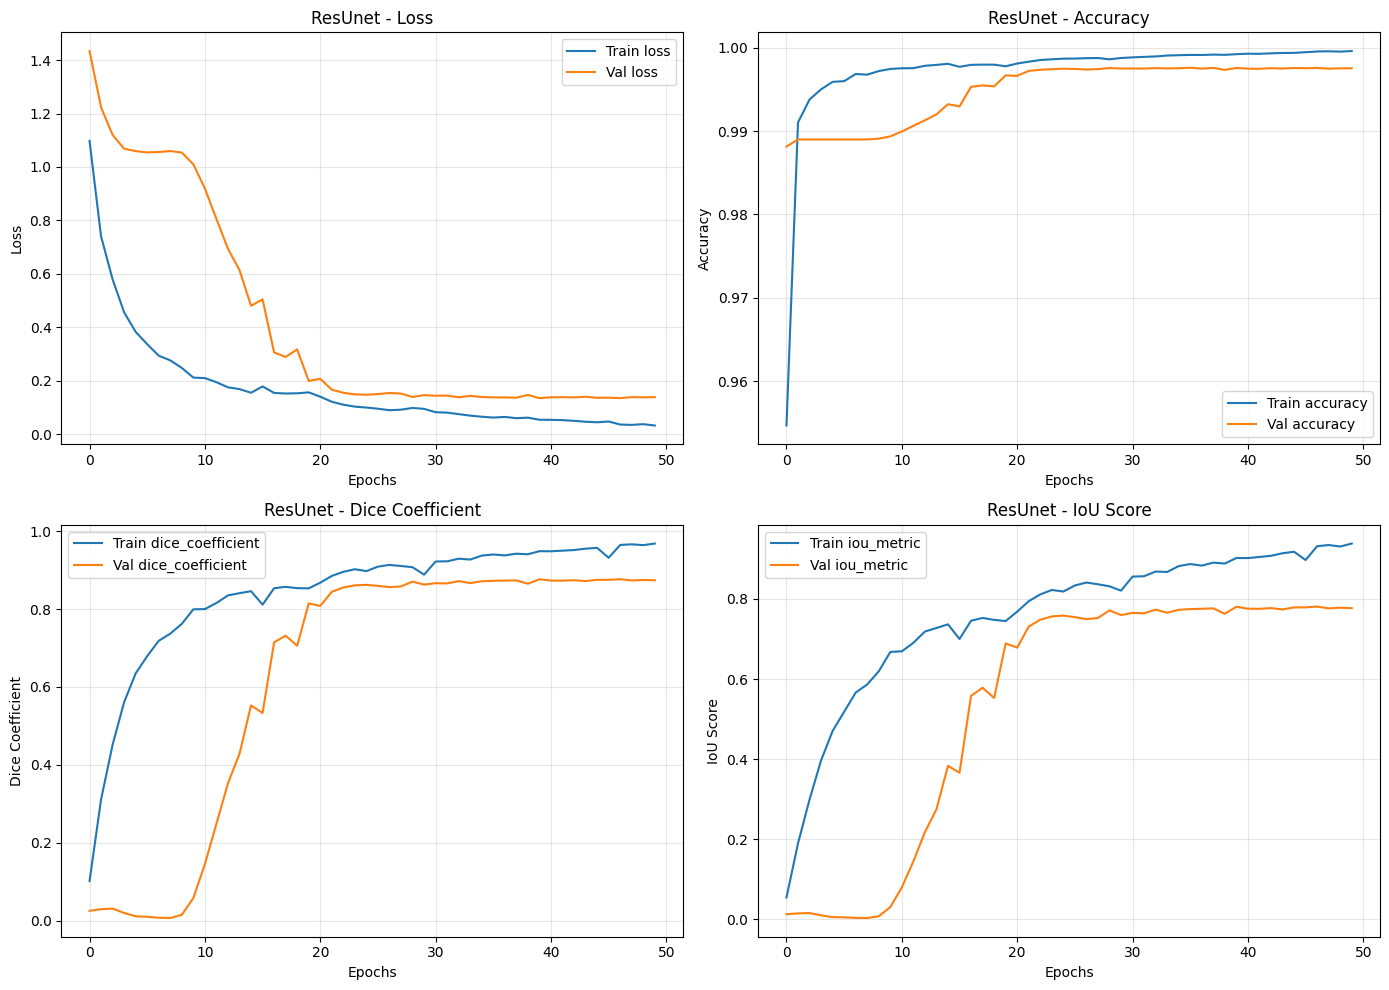

(<Functional name=functional_1, built=True>,
 <keras.src.callbacks.history.History at 0x7868ae5c94f0>)

In [28]:
train_model(ResUnet, X_train, y_train, X_val, y_val, model_name='ResUnet', epochs=50, batch_size=32)


Training DeepLab...
----------------------------------------
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.7073 - dice_coefficient: 0.0316 - iou_metric: 0.0161 - loss: 1.5836
Epoch 1: val_dice_coefficient improved from -inf to 0.02283, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.7110 - dice_coefficient: 0.0320 - iou_metric: 0.0163 - loss: 1.5796 - val_accuracy: 0.9889 - val_dice_coefficient: 0.0228 - val_iou_metric: 0.0116 - val_loss: 1.5410 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9837 - dice_coefficient: 0.0620 - iou_metric: 0.0321 - loss: 1.1910
Epoch 2: val_dice_coefficient improved from 0.02283 to 0.02630, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 351ms/step - accuracy: 0.9837 - dice_coefficient: 0.0623 - iou_metric: 0.0323 - loss: 1.1899 - val_accuracy: 0.9883 - val_dice_coefficient: 0.0263 - val_iou_metric: 0.0133 - val_loss: 1.4458 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.9886 - dice_coefficient: 0.0831 - iou_metric: 0.0436 - loss: 1.0949
Epoch 3: val_dice_coefficient improved from 0.02630 to 0.02666, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.9887 - dice_coefficient: 0.0834 - iou_metric: 0.0438 - loss: 1.0942 - val_accuracy: 0.9827 - val_dice_coefficient: 0.0267 - val_iou_metric: 0.0135 - val_loss: 1.4707 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9902 - dice_coefficient: 0.1052 - iou_metric: 0.0557 - loss: 1.0463
Epoch 4: val_dice_coefficient did not improve from 0.02666
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9902 - dice_coefficient: 0.1055 - iou_metric: 0.0559 - loss: 1.0458 - val_accuracy: 0.9890 - val_dice_coefficient: 0.0181 - val_iou_metric: 0.0091 - val_loss: 1.4548 - learning_rate: 1.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.9913 - dice_coefficient: 0.1300 - iou_metric: 0.0702 - loss: 0.9999
Epoch 5: val_dice_coefficient did not improve from 0.02666
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.9913 - dice_coefficient: 0.1299 - iou_metric: 0.0701 - los

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.9939 - dice_coefficient: 0.1939 - iou_metric: 0.1082 - loss: 0.8866 - val_accuracy: 0.9895 - val_dice_coefficient: 0.0313 - val_iou_metric: 0.0159 - val_loss: 1.1003 - learning_rate: 1.0000e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9939 - dice_coefficient: 0.2101 - iou_metric: 0.1189 - loss: 0.8647
Epoch 11: val_dice_coefficient improved from 0.03132 to 0.03778, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.9939 - dice_coefficient: 0.2101 - iou_metric: 0.1190 - loss: 0.8646 - val_accuracy: 0.9898 - val_dice_coefficient: 0.0378 - val_iou_metric: 0.0193 - val_loss: 1.0770 - learning_rate: 1.0000e-04
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9947 - dice_coefficient: 0.2188 - iou_metric: 0.1242 - loss: 0.8507
Epoch 12: val_dice_coefficient improved from 0.03778 to 0.04741, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9947 - dice_coefficient: 0.2193 - iou_metric: 0.1245 - loss: 0.8503 - val_accuracy: 0.9903 - val_dice_coefficient: 0.0474 - val_iou_metric: 0.0244 - val_loss: 1.0589 - learning_rate: 1.0000e-04
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9945 - dice_coefficient: 0.2412 - iou_metric: 0.1385 - loss: 0.8252
Epoch 13: val_dice_coefficient improved from 0.04741 to 0.07647, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.9945 - dice_coefficient: 0.2412 - iou_metric: 0.1385 - loss: 0.8251 - val_accuracy: 0.9915 - val_dice_coefficient: 0.0765 - val_iou_metric: 0.0399 - val_loss: 1.0230 - learning_rate: 1.0000e-04
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9950 - dice_coefficient: 0.2469 - iou_metric: 0.1423 - loss: 0.8151
Epoch 14: val_dice_coefficient did not improve from 0.07647
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 350ms/step - accuracy: 0.9949 - dice_coefficient: 0.2471 - iou_metric: 0.1425 - loss: 0.8148 - val_accuracy: 0.9910 - val_dice_coefficient: 0.0701 - val_iou_metric: 0.0365 - val_loss: 1.0196 - learning_rate: 1.0000e-04
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9948 - dice_coefficient: 0.2659 - iou_metric: 0.1548 - loss: 0.7903
Epoch 15: val_dice_coefficient improved from 0.07647 to 0.11683, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.9948 - dice_coefficient: 0.2660 - iou_metric: 0.1548 - loss: 0.7901 - val_accuracy: 0.9922 - val_dice_coefficient: 0.1168 - val_iou_metric: 0.0624 - val_loss: 0.9546 - learning_rate: 1.0000e-04
Epoch 16/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9951 - dice_coefficient: 0.2822 - iou_metric: 0.1667 - loss: 0.7716
Epoch 16: val_dice_coefficient improved from 0.11683 to 0.18899, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9951 - dice_coefficient: 0.2827 - iou_metric: 0.1670 - loss: 0.7711 - val_accuracy: 0.9942 - val_dice_coefficient: 0.1890 - val_iou_metric: 0.1050 - val_loss: 0.8687 - learning_rate: 1.0000e-04
Epoch 17/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9960 - dice_coefficient: 0.3252 - iou_metric: 0.1960 - loss: 0.7213
Epoch 17: val_dice_coefficient improved from 0.18899 to 0.22464, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9959 - dice_coefficient: 0.3253 - iou_metric: 0.1960 - loss: 0.7213 - val_accuracy: 0.9950 - val_dice_coefficient: 0.2246 - val_iou_metric: 0.1273 - val_loss: 0.8305 - learning_rate: 1.0000e-04
Epoch 18/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9958 - dice_coefficient: 0.3493 - iou_metric: 0.2137 - loss: 0.6947
Epoch 18: val_dice_coefficient improved from 0.22464 to 0.25109, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9958 - dice_coefficient: 0.3491 - iou_metric: 0.2136 - loss: 0.6950 - val_accuracy: 0.9953 - val_dice_coefficient: 0.2511 - val_iou_metric: 0.1443 - val_loss: 0.8023 - learning_rate: 1.0000e-04
Epoch 19/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9959 - dice_coefficient: 0.3507 - iou_metric: 0.2158 - loss: 0.6907
Epoch 19: val_dice_coefficient improved from 0.25109 to 0.28547, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9959 - dice_coefficient: 0.3508 - iou_metric: 0.2159 - loss: 0.6907 - val_accuracy: 0.9922 - val_dice_coefficient: 0.2855 - val_iou_metric: 0.1673 - val_loss: 0.7717 - learning_rate: 1.0000e-04
Epoch 20/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9954 - dice_coefficient: 0.3725 - iou_metric: 0.2309 - loss: 0.6666
Epoch 20: val_dice_coefficient improved from 0.28547 to 0.32945, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.9954 - dice_coefficient: 0.3723 - iou_metric: 0.2308 - loss: 0.6666 - val_accuracy: 0.9953 - val_dice_coefficient: 0.3295 - val_iou_metric: 0.1982 - val_loss: 0.7165 - learning_rate: 1.0000e-04
Epoch 21/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9962 - dice_coefficient: 0.4011 - iou_metric: 0.2531 - loss: 0.6336
Epoch 21: val_dice_coefficient improved from 0.32945 to 0.35071, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.9962 - dice_coefficient: 0.4012 - iou_metric: 0.2531 - loss: 0.6336 - val_accuracy: 0.9957 - val_dice_coefficient: 0.3507 - val_iou_metric: 0.2137 - val_loss: 0.6904 - learning_rate: 1.0000e-04
Epoch 22/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9960 - dice_coefficient: 0.4049 - iou_metric: 0.2569 - loss: 0.6306
Epoch 22: val_dice_coefficient improved from 0.35071 to 0.38782, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.9960 - dice_coefficient: 0.4049 - iou_metric: 0.2570 - loss: 0.6305 - val_accuracy: 0.9947 - val_dice_coefficient: 0.3878 - val_iou_metric: 0.2417 - val_loss: 0.6555 - learning_rate: 1.0000e-04
Epoch 23/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9957 - dice_coefficient: 0.4426 - iou_metric: 0.2900 - loss: 0.5911
Epoch 23: val_dice_coefficient improved from 0.38782 to 0.40261, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9957 - dice_coefficient: 0.4419 - iou_metric: 0.2894 - loss: 0.5916 - val_accuracy: 0.9960 - val_dice_coefficient: 0.4026 - val_iou_metric: 0.2534 - val_loss: 0.6329 - learning_rate: 1.0000e-04
Epoch 24/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9964 - dice_coefficient: 0.4328 - iou_metric: 0.2805 - loss: 0.5986
Epoch 24: val_dice_coefficient improved from 0.40261 to 0.41483, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9964 - dice_coefficient: 0.4333 - iou_metric: 0.2809 - loss: 0.5980 - val_accuracy: 0.9956 - val_dice_coefficient: 0.4148 - val_iou_metric: 0.2628 - val_loss: 0.6220 - learning_rate: 1.0000e-04
Epoch 25/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9963 - dice_coefficient: 0.4634 - iou_metric: 0.3071 - loss: 0.5656
Epoch 25: val_dice_coefficient did not improve from 0.41483
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9963 - dice_coefficient: 0.4635 - iou_metric: 0.3072 - loss: 0.5654 - val_accuracy: 0.9966 - val_dice_coefficient: 0.4021 - val_iou_metric: 0.2528 - val_loss: 0.6312 - learning_rate: 1.0000e-04
Epoch 26/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9969 - dice_coefficient: 0.5146 - iou_metric: 0.3503 - loss: 0.5103
Epoch 26: val_dice_coefficient improved from 0.41483 to 0.46105, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9969 - dice_coefficient: 0.5140 - iou_metric: 0.3498 - loss: 0.5107 - val_accuracy: 0.9965 - val_dice_coefficient: 0.4610 - val_iou_metric: 0.3009 - val_loss: 0.5648 - learning_rate: 1.0000e-04
Epoch 27/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9969 - dice_coefficient: 0.4981 - iou_metric: 0.3376 - loss: 0.5274
Epoch 27: val_dice_coefficient improved from 0.46105 to 0.50309, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9969 - dice_coefficient: 0.4988 - iou_metric: 0.3383 - loss: 0.5267 - val_accuracy: 0.9956 - val_dice_coefficient: 0.5031 - val_iou_metric: 0.3373 - val_loss: 0.5261 - learning_rate: 1.0000e-04
Epoch 28/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9962 - dice_coefficient: 0.5266 - iou_metric: 0.3609 - loss: 0.4995
Epoch 28: val_dice_coefficient improved from 0.50309 to 0.51581, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.9962 - dice_coefficient: 0.5269 - iou_metric: 0.3611 - loss: 0.4993 - val_accuracy: 0.9964 - val_dice_coefficient: 0.5158 - val_iou_metric: 0.3489 - val_loss: 0.5098 - learning_rate: 1.0000e-04
Epoch 29/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9968 - dice_coefficient: 0.5702 - iou_metric: 0.4027 - loss: 0.4519
Epoch 29: val_dice_coefficient improved from 0.51581 to 0.56011, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9968 - dice_coefficient: 0.5700 - iou_metric: 0.4025 - loss: 0.4521 - val_accuracy: 0.9965 - val_dice_coefficient: 0.5601 - val_iou_metric: 0.3903 - val_loss: 0.4622 - learning_rate: 1.0000e-04
Epoch 30/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9975 - dice_coefficient: 0.5914 - iou_metric: 0.4236 - loss: 0.4278
Epoch 30: val_dice_coefficient improved from 0.56011 to 0.58010, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.9975 - dice_coefficient: 0.5914 - iou_metric: 0.4236 - loss: 0.4279 - val_accuracy: 0.9965 - val_dice_coefficient: 0.5801 - val_iou_metric: 0.4099 - val_loss: 0.4423 - learning_rate: 1.0000e-04
Epoch 31/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9973 - dice_coefficient: 0.5808 - iou_metric: 0.4125 - loss: 0.4386
Epoch 31: val_dice_coefficient improved from 0.58010 to 0.60079, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9973 - dice_coefficient: 0.5814 - iou_metric: 0.4132 - loss: 0.4380 - val_accuracy: 0.9961 - val_dice_coefficient: 0.6008 - val_iou_metric: 0.4309 - val_loss: 0.4231 - learning_rate: 1.0000e-04
Epoch 32/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9973 - dice_coefficient: 0.6168 - iou_metric: 0.4500 - loss: 0.4023
Epoch 32: val_dice_coefficient improved from 0.60079 to 0.63822, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9973 - dice_coefficient: 0.6169 - iou_metric: 0.4500 - loss: 0.4020 - val_accuracy: 0.9966 - val_dice_coefficient: 0.6382 - val_iou_metric: 0.4700 - val_loss: 0.3817 - learning_rate: 1.0000e-04
Epoch 33/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9975 - dice_coefficient: 0.6300 - iou_metric: 0.4643 - loss: 0.3870
Epoch 33: val_dice_coefficient improved from 0.63822 to 0.64568, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9975 - dice_coefficient: 0.6304 - iou_metric: 0.4647 - loss: 0.3867 - val_accuracy: 0.9969 - val_dice_coefficient: 0.6457 - val_iou_metric: 0.4779 - val_loss: 0.3713 - learning_rate: 1.0000e-04
Epoch 34/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9974 - dice_coefficient: 0.6533 - iou_metric: 0.4875 - loss: 0.3636
Epoch 34: val_dice_coefficient improved from 0.64568 to 0.64916, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9974 - dice_coefficient: 0.6533 - iou_metric: 0.4876 - loss: 0.3636 - val_accuracy: 0.9968 - val_dice_coefficient: 0.6492 - val_iou_metric: 0.4817 - val_loss: 0.3685 - learning_rate: 1.0000e-04
Epoch 35/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9973 - dice_coefficient: 0.6655 - iou_metric: 0.5048 - loss: 0.3515
Epoch 35: val_dice_coefficient improved from 0.64916 to 0.65353, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.9973 - dice_coefficient: 0.6652 - iou_metric: 0.5045 - loss: 0.3518 - val_accuracy: 0.9969 - val_dice_coefficient: 0.6535 - val_iou_metric: 0.4866 - val_loss: 0.3622 - learning_rate: 1.0000e-04
Epoch 36/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9976 - dice_coefficient: 0.6831 - iou_metric: 0.5210 - loss: 0.3324
Epoch 36: val_dice_coefficient improved from 0.65353 to 0.66703, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9976 - dice_coefficient: 0.6832 - iou_metric: 0.5212 - loss: 0.3322 - val_accuracy: 0.9959 - val_dice_coefficient: 0.6670 - val_iou_metric: 0.5018 - val_loss: 0.3571 - learning_rate: 1.0000e-04
Epoch 37/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9970 - dice_coefficient: 0.6615 - iou_metric: 0.5023 - loss: 0.3553
Epoch 37: val_dice_coefficient did not improve from 0.66703
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9970 - dice_coefficient: 0.6616 - iou_metric: 0.5025 - loss: 0.3553 - val_accuracy: 0.9936 - val_dice_coefficient: 0.6346 - val_iou_metric: 0.4664 - val_loss: 0.4016 - learning_rate: 1.0000e-04
Epoch 38/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9972 - dice_coefficient: 0.7016 - iou_metric: 0.5434 - loss: 0.3146
Epoch 38: val_dice_coefficient improved from 0.66703 to 0.69246, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.9972 - dice_coefficient: 0.7010 - iou_metric: 0.5429 - loss: 0.3147 - val_accuracy: 0.9962 - val_dice_coefficient: 0.6925 - val_iou_metric: 0.5308 - val_loss: 0.3253 - learning_rate: 1.0000e-04
Epoch 39/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9975 - dice_coefficient: 0.6865 - iou_metric: 0.5295 - loss: 0.3277
Epoch 39: val_dice_coefficient improved from 0.69246 to 0.69904, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9975 - dice_coefficient: 0.6864 - iou_metric: 0.5294 - loss: 0.3276 - val_accuracy: 0.9952 - val_dice_coefficient: 0.6990 - val_iou_metric: 0.5385 - val_loss: 0.3301 - learning_rate: 1.0000e-04
Epoch 40/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9974 - dice_coefficient: 0.7108 - iou_metric: 0.5596 - loss: 0.3045
Epoch 40: val_dice_coefficient improved from 0.69904 to 0.71848, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.9974 - dice_coefficient: 0.7111 - iou_metric: 0.5599 - loss: 0.3043 - val_accuracy: 0.9968 - val_dice_coefficient: 0.7185 - val_iou_metric: 0.5617 - val_loss: 0.2961 - learning_rate: 1.0000e-04
Epoch 41/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9978 - dice_coefficient: 0.7345 - iou_metric: 0.5843 - loss: 0.2784
Epoch 41: val_dice_coefficient improved from 0.71848 to 0.72714, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.9978 - dice_coefficient: 0.7347 - iou_metric: 0.5845 - loss: 0.2782 - val_accuracy: 0.9971 - val_dice_coefficient: 0.7271 - val_iou_metric: 0.5721 - val_loss: 0.2861 - learning_rate: 1.0000e-04
Epoch 42/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9978 - dice_coefficient: 0.7392 - iou_metric: 0.5901 - loss: 0.2732
Epoch 42: val_dice_coefficient improved from 0.72714 to 0.73250, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.9978 - dice_coefficient: 0.7396 - iou_metric: 0.5906 - loss: 0.2728 - val_accuracy: 0.9967 - val_dice_coefficient: 0.7325 - val_iou_metric: 0.5789 - val_loss: 0.2848 - learning_rate: 1.0000e-04
Epoch 43/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9978 - dice_coefficient: 0.7625 - iou_metric: 0.6188 - loss: 0.2500
Epoch 43: val_dice_coefficient improved from 0.73250 to 0.73815, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9978 - dice_coefficient: 0.7621 - iou_metric: 0.6185 - loss: 0.2501 - val_accuracy: 0.9966 - val_dice_coefficient: 0.7382 - val_iou_metric: 0.5859 - val_loss: 0.2790 - learning_rate: 1.0000e-04
Epoch 44/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9978 - dice_coefficient: 0.7525 - iou_metric: 0.6069 - loss: 0.2598
Epoch 44: val_dice_coefficient did not improve from 0.73815
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9978 - dice_coefficient: 0.7527 - iou_metric: 0.6071 - loss: 0.2596 - val_accuracy: 0.9970 - val_dice_coefficient: 0.7357 - val_iou_metric: 0.5827 - val_loss: 0.2772 - learning_rate: 1.0000e-04
Epoch 45/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9976 - dice_coefficient: 0.7492 - iou_metric: 0.6021 - loss: 0.2639
Epoch 45: val_dice_coefficient improved from 0.73815 to 0.77520, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9976 - dice_coefficient: 0.7493 - iou_metric: 0.6022 - loss: 0.2637 - val_accuracy: 0.9969 - val_dice_coefficient: 0.7752 - val_iou_metric: 0.6335 - val_loss: 0.2419 - learning_rate: 1.0000e-04
Epoch 46/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9977 - dice_coefficient: 0.7816 - iou_metric: 0.6436 - loss: 0.2300
Epoch 46: val_dice_coefficient did not improve from 0.77520
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9977 - dice_coefficient: 0.7814 - iou_metric: 0.6434 - loss: 0.2301 - val_accuracy: 0.9971 - val_dice_coefficient: 0.7647 - val_iou_metric: 0.6198 - val_loss: 0.2480 - learning_rate: 1.0000e-04
Epoch 47/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9979 - dice_coefficient: 0.7756 - iou_metric: 0.6372 - loss: 0.2360
Epoch 47: val_dice_coefficient did not improve from 0.77520
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9979 - dice_coefficient: 0.7759 - iou_metric: 0.6376 -

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9978 - dice_coefficient: 0.8022 - iou_metric: 0.6721 - loss: 0.2091 - val_accuracy: 0.9969 - val_dice_coefficient: 0.7777 - val_iou_metric: 0.6371 - val_loss: 0.2379 - learning_rate: 1.0000e-04
Epoch 49/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.9981 - dice_coefficient: 0.7980 - iou_metric: 0.6659 - loss: 0.2122
Epoch 49: val_dice_coefficient improved from 0.77766 to 0.78013, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 352ms/step - accuracy: 0.9981 - dice_coefficient: 0.7981 - iou_metric: 0.6660 - loss: 0.2121 - val_accuracy: 0.9971 - val_dice_coefficient: 0.7801 - val_iou_metric: 0.6403 - val_loss: 0.2311 - learning_rate: 1.0000e-04
Epoch 50/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9980 - dice_coefficient: 0.8099 - iou_metric: 0.6835 - loss: 0.2005
Epoch 50: val_dice_coefficient improved from 0.78013 to 0.78576, saving model to best_DeepLab.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 353ms/step - accuracy: 0.9980 - dice_coefficient: 0.8099 - iou_metric: 0.6834 - loss: 0.2005 - val_accuracy: 0.9972 - val_dice_coefficient: 0.7858 - val_iou_metric: 0.6478 - val_loss: 0.2261 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 50.


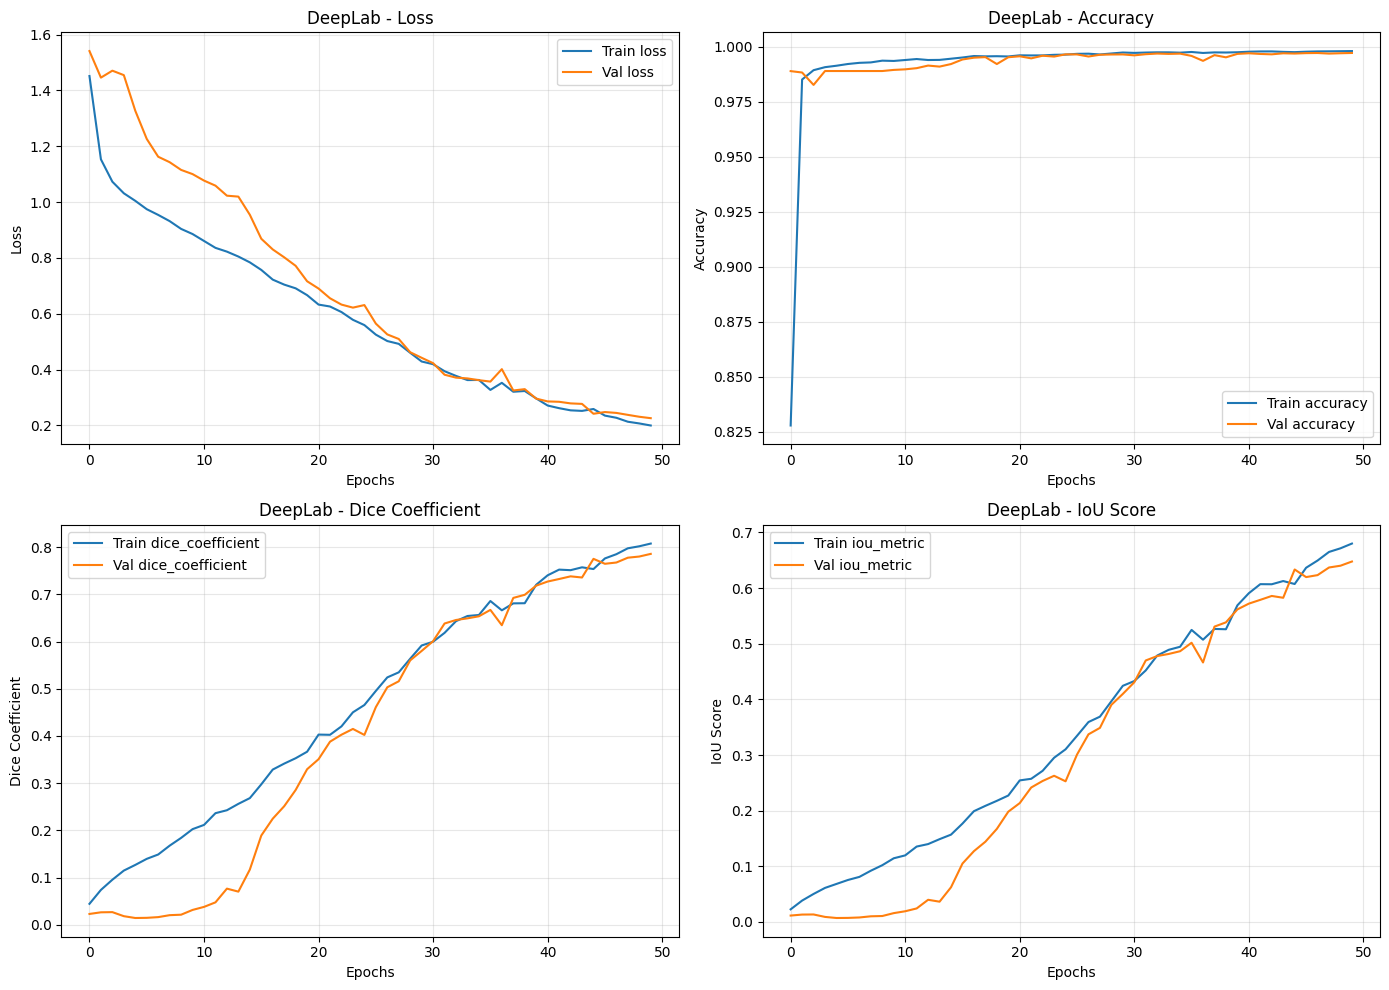

(<Functional name=functional_2, built=True>,
 <keras.src.callbacks.history.History at 0x7868505e2180>)

In [29]:
train_model(DeepLab, X_train, y_train, X_val, y_val, model_name='DeepLab',epochs=50, batch_size=32)

In [30]:
def evaluate_model(model, X_test, y_test, model_name, plot_curves=True):
    print(f"\nEvaluating {model_name}...")
    print("-" * 40)

    # Predict
    y_pred = model.predict(X_test, batch_size=32, verbose=1)
    y_pred_binary = (y_pred > 0.5).astype(np.float32)

    # Flatten for sklearn metrics
    y_true_flat = y_test.reshape(-1).astype(np.int32)
    y_pred_flat = y_pred_binary.reshape(-1).astype(np.int32)
    y_pred_prob_flat = y_pred.reshape(-1)

    # Calculate metrics
    precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)
    iou = jaccard_score(y_true_flat, y_pred_flat, zero_division=0)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"IoU: {iou:.4f}")

    # Calculate dice score
    dice = dice_coefficient(
        tf.convert_to_tensor(y_test),
        tf.convert_to_tensor(y_pred_binary)
    )
    print(f"Dice Coefficient: {dice:.4f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true_flat, y_pred_prob_flat)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_true_flat, y_pred_prob_flat)
    pr_auc = auc(recall_curve, precision_curve)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    # Plot curves if requested
    if plot_curves:
        plot_single_model_curves(y_true_flat, y_pred_prob_flat, model_name, fpr, tpr, roc_auc, recall_curve, precision_curve, pr_auc)

    return {
        'model_name': model_name,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'iou': iou,
        'dice': float(dice),
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_pred': y_pred,
        'y_pred_binary': y_pred_binary,
        'fpr': fpr,
        'tpr': tpr,
        'precision_curve': precision_curve,
        'recall_curve': recall_curve
    }

def plot_single_model_curves(y_true, y_pred_prob, model_name, fpr, tpr, roc_auc, recall_curve, precision_curve, pr_auc):
    """Plot ROC and PR curves for a single model"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ROC Curve
    axes[0].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[0].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(f'{model_name} - ROC Curve')
    axes[0].legend(loc="lower right")
    axes[0].grid(True, alpha=0.3)

    # Precision-Recall Curve
    axes[1].plot(recall_curve, precision_curve, color='red', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title(f'{model_name} - Precision-Recall Curve')
    axes[1].legend(loc="lower left")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_roc_curves(all_metrics, y_test):
    """Plot ROC curves for multiple models"""
    plt.figure(figsize=(10, 6))

    for metrics in all_metrics:
        y_true_flat = y_test.reshape(-1).astype(np.int32)
        y_pred_prob_flat = metrics['y_pred'].reshape(-1)

        fpr, tpr, _ = roc_curve(y_true_flat, y_pred_prob_flat)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"{metrics['model_name']} (AUC = {roc_auc:.3f})", linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Model Comparison', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_pr_curves(all_metrics, y_test):
    """Plot Precision-Recall curves for multiple models"""
    plt.figure(figsize=(10, 6))

    for metrics in all_metrics:
        y_true_flat = y_test.reshape(-1).astype(np.int32)
        y_pred_prob_flat = metrics['y_pred'].reshape(-1)

        precision, recall, _ = precision_recall_curve(y_true_flat, y_pred_prob_flat)
        pr_auc = auc(recall, precision)

        plt.plot(recall, precision, label=f"{metrics['model_name']} (AUC = {pr_auc:.3f})", linewidth=2)

    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curves - Model Comparison', fontsize=14)
    plt.legend(loc='lower left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.show()

In [31]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_curve, auc,
    jaccard_score, precision_recall_curve
)



Evaluating UNet...
----------------------------------------
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step
Precision: 0.8933
Recall: 0.8399
F1-Score: 0.8657
IoU: 0.7633
Dice Coefficient: 0.8657
ROC AUC: 0.9739
PR AUC: 0.9039


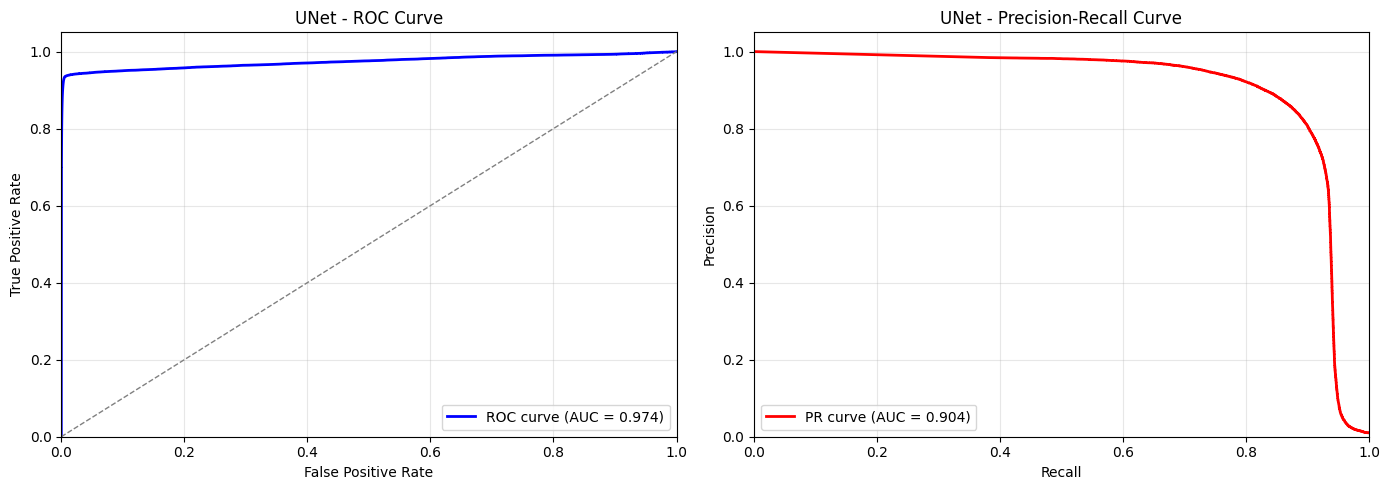

In [32]:
# This will show plots immediately
uNet_metrics = evaluate_model(uNet, X_test, y_test, model_name='UNet', plot_curves=True)


Evaluating ResUNet...
----------------------------------------
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step
Precision: 0.9150
Recall: 0.8319
F1-Score: 0.8715
IoU: 0.7722
Dice Coefficient: 0.8715
ROC AUC: 0.9466
PR AUC: 0.9005


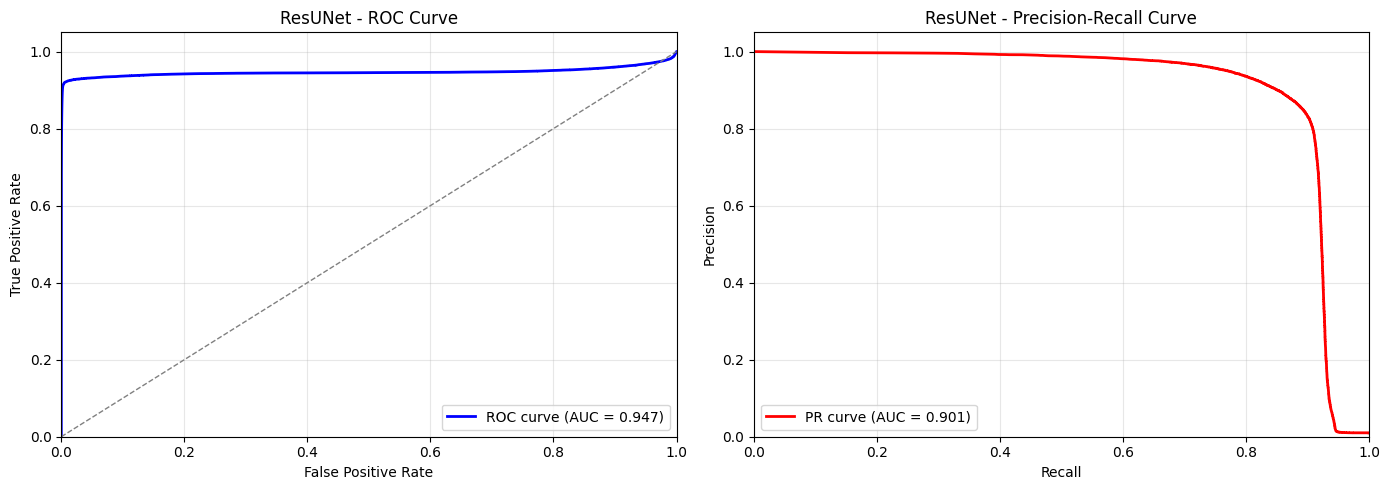

In [33]:
ResUnet_metrics = evaluate_model(ResUnet, X_test, y_test, model_name='ResUNet', plot_curves=True)


Evaluating DeepLab...
----------------------------------------


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step
Precision: 0.9018
Recall: 0.8255
F1-Score: 0.8620
IoU: 0.7574
Dice Coefficient: 0.8620
ROC AUC: 0.9878
PR AUC: 0.9107


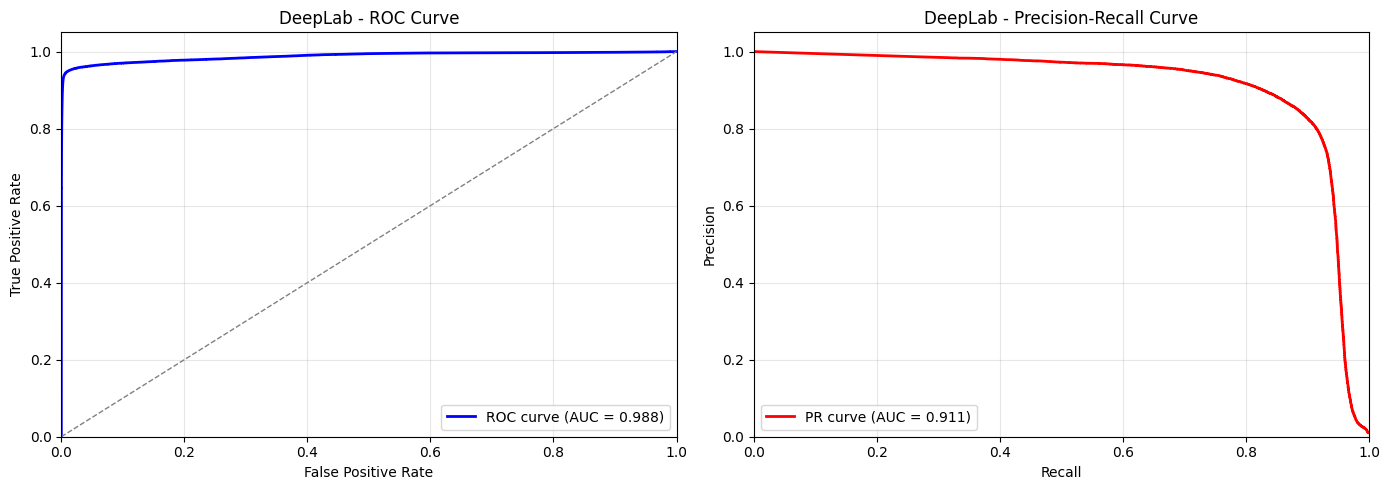

{'model_name': 'DeepLab',
 'precision': 0.9017917201736685,
 'recall': 0.8255381084333977,
 'f1_score': 0.8619817924100945,
 'iou': np.float64(0.7574411258635302),
 'dice': 0.8619818091392517,
 'roc_auc': np.float64(0.9878362304663725),
 'pr_auc': np.float64(0.9107262047021295),
 'y_pred': array([[[[0.00207059],
          [0.00183308],
          [0.00171539],
          ...,
          [0.00168649],
          [0.00173312],
          [0.0020861 ]],
 
         [[0.00215627],
          [0.00199175],
          [0.0017772 ],
          ...,
          [0.00173617],
          [0.00179015],
          [0.00184888]],
 
         [[0.00176322],
          [0.00174634],
          [0.0017593 ],
          ...,
          [0.00177378],
          [0.00174552],
          [0.00175902]],
 
         ...,
 
         [[0.00176616],
          [0.00174184],
          [0.00173857],
          ...,
          [0.00178839],
          [0.00166481],
          [0.00162248]],
 
         [[0.00184269],
          [0.00184119]

In [34]:
evaluate_model(DeepLab, X_test, y_test, model_name='DeepLab', plot_curves=True)

In [35]:
def visualize_predictions(model, X_test, y_test, filenames=None, num_samples=5, model_name="Model"):
    indices = np.random.choice(len(X_test), num_samples, replace=False)

    plt.figure(figsize=(12, num_samples * 4))

    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_mask = y_test[idx].squeeze()

        # Predict
        pred = model.predict(np.expand_dims(img, axis=0))[0]
        pred_binary = (pred > 0.5).astype(np.float32).squeeze()

        # Original Image
        plt.subplot(num_samples, 4, 4*i+1)
        plt.imshow(img)
        title = filenames[idx] if filenames else f"Sample {idx}"
        plt.title(f"Original\n{title}")
        plt.axis('off')

        # True Mask
        plt.subplot(num_samples, 4, 4*i+2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 4, 4*i+3)
        plt.imshow(pred_binary, cmap='gray')
        plt.title(f"{model_name} Prediction")
        plt.axis('off')

        # Overlay Prediction on Image
        plt.subplot(num_samples, 4, 4*i+4)
        plt.imshow(img)
        plt.imshow(pred_binary, cmap='Reds', alpha=0.4)
        plt.title("Prediction Overlay")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


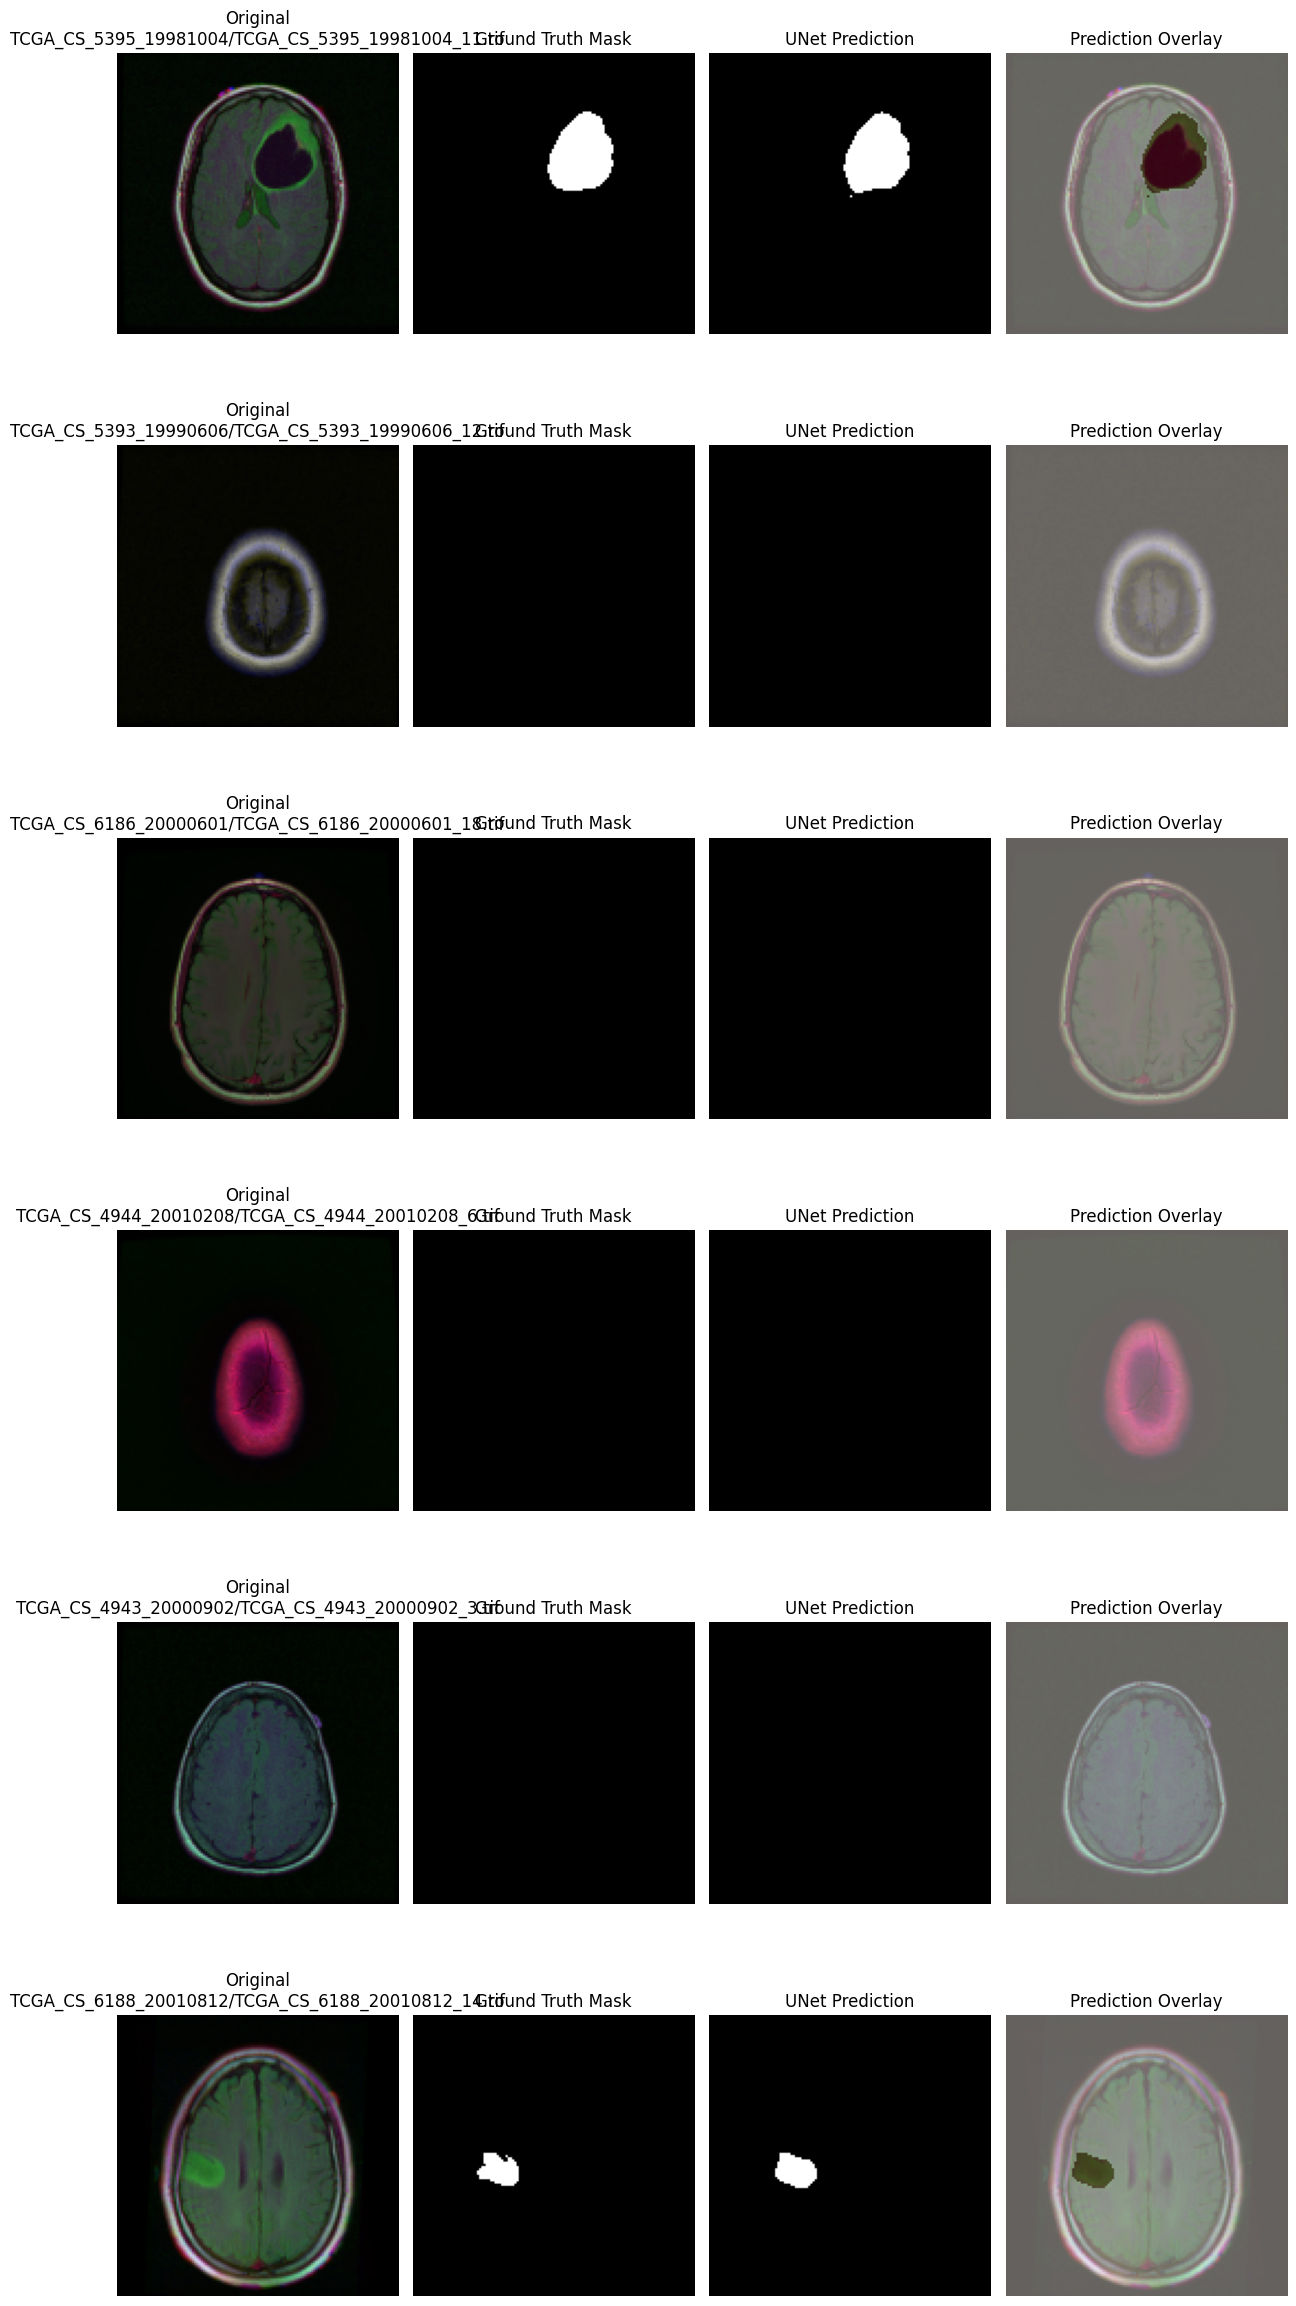

In [36]:
visualize_predictions(uNet, X_test, y_test, filenames, num_samples=6, model_name="UNet")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


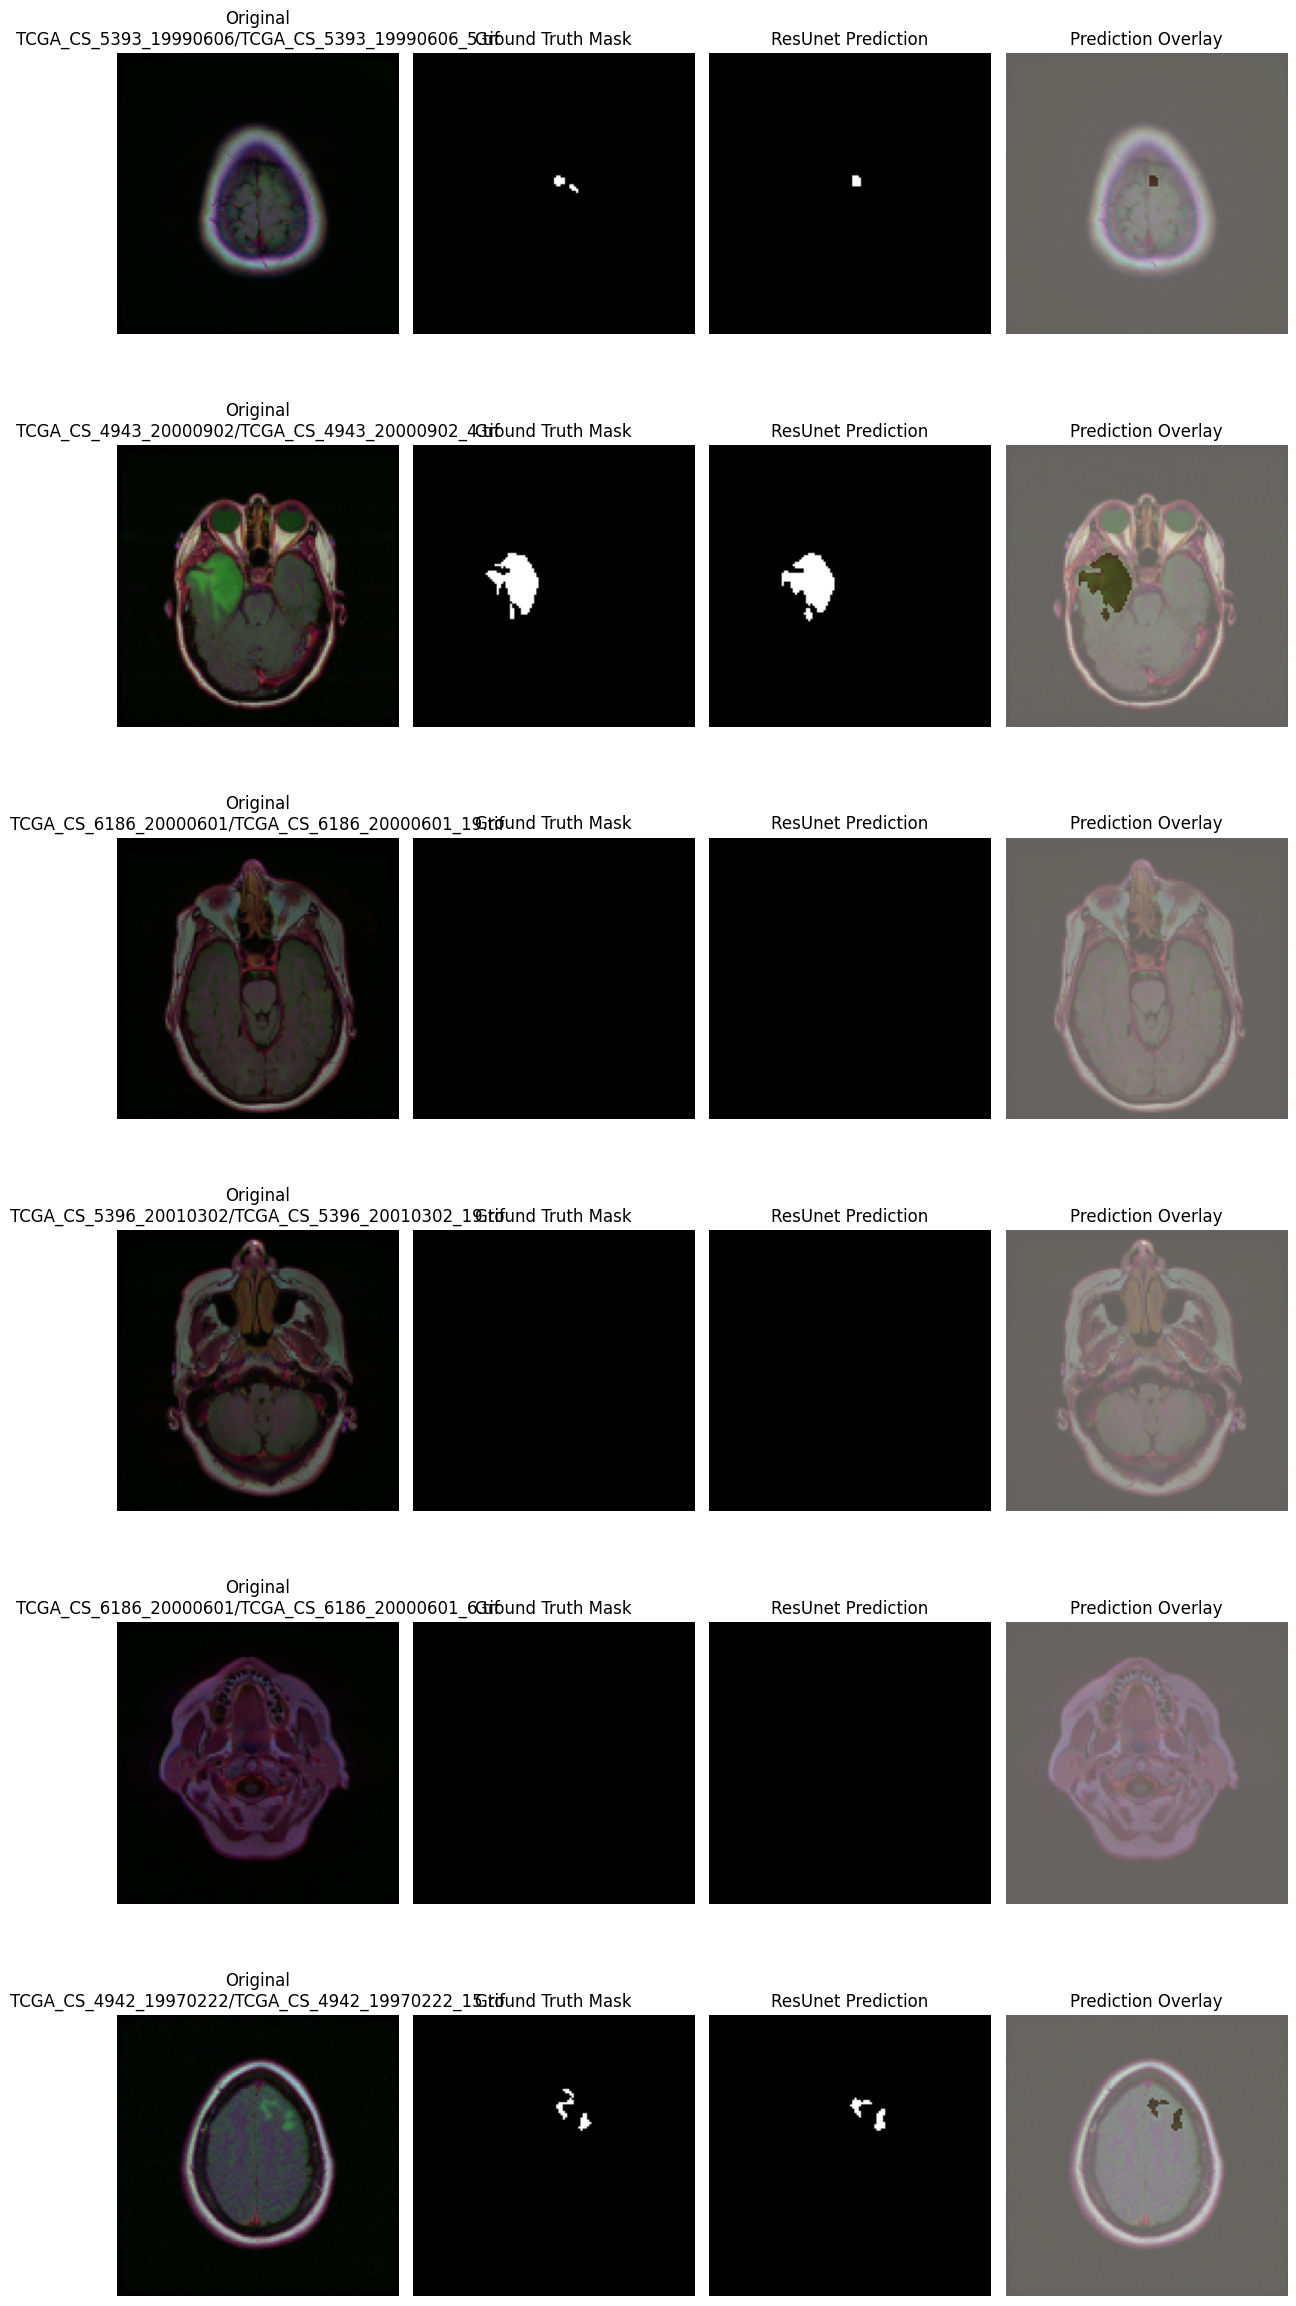

In [37]:
visualize_predictions(ResUnet, X_test, y_test, filenames, num_samples=6, model_name="ResUnet")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


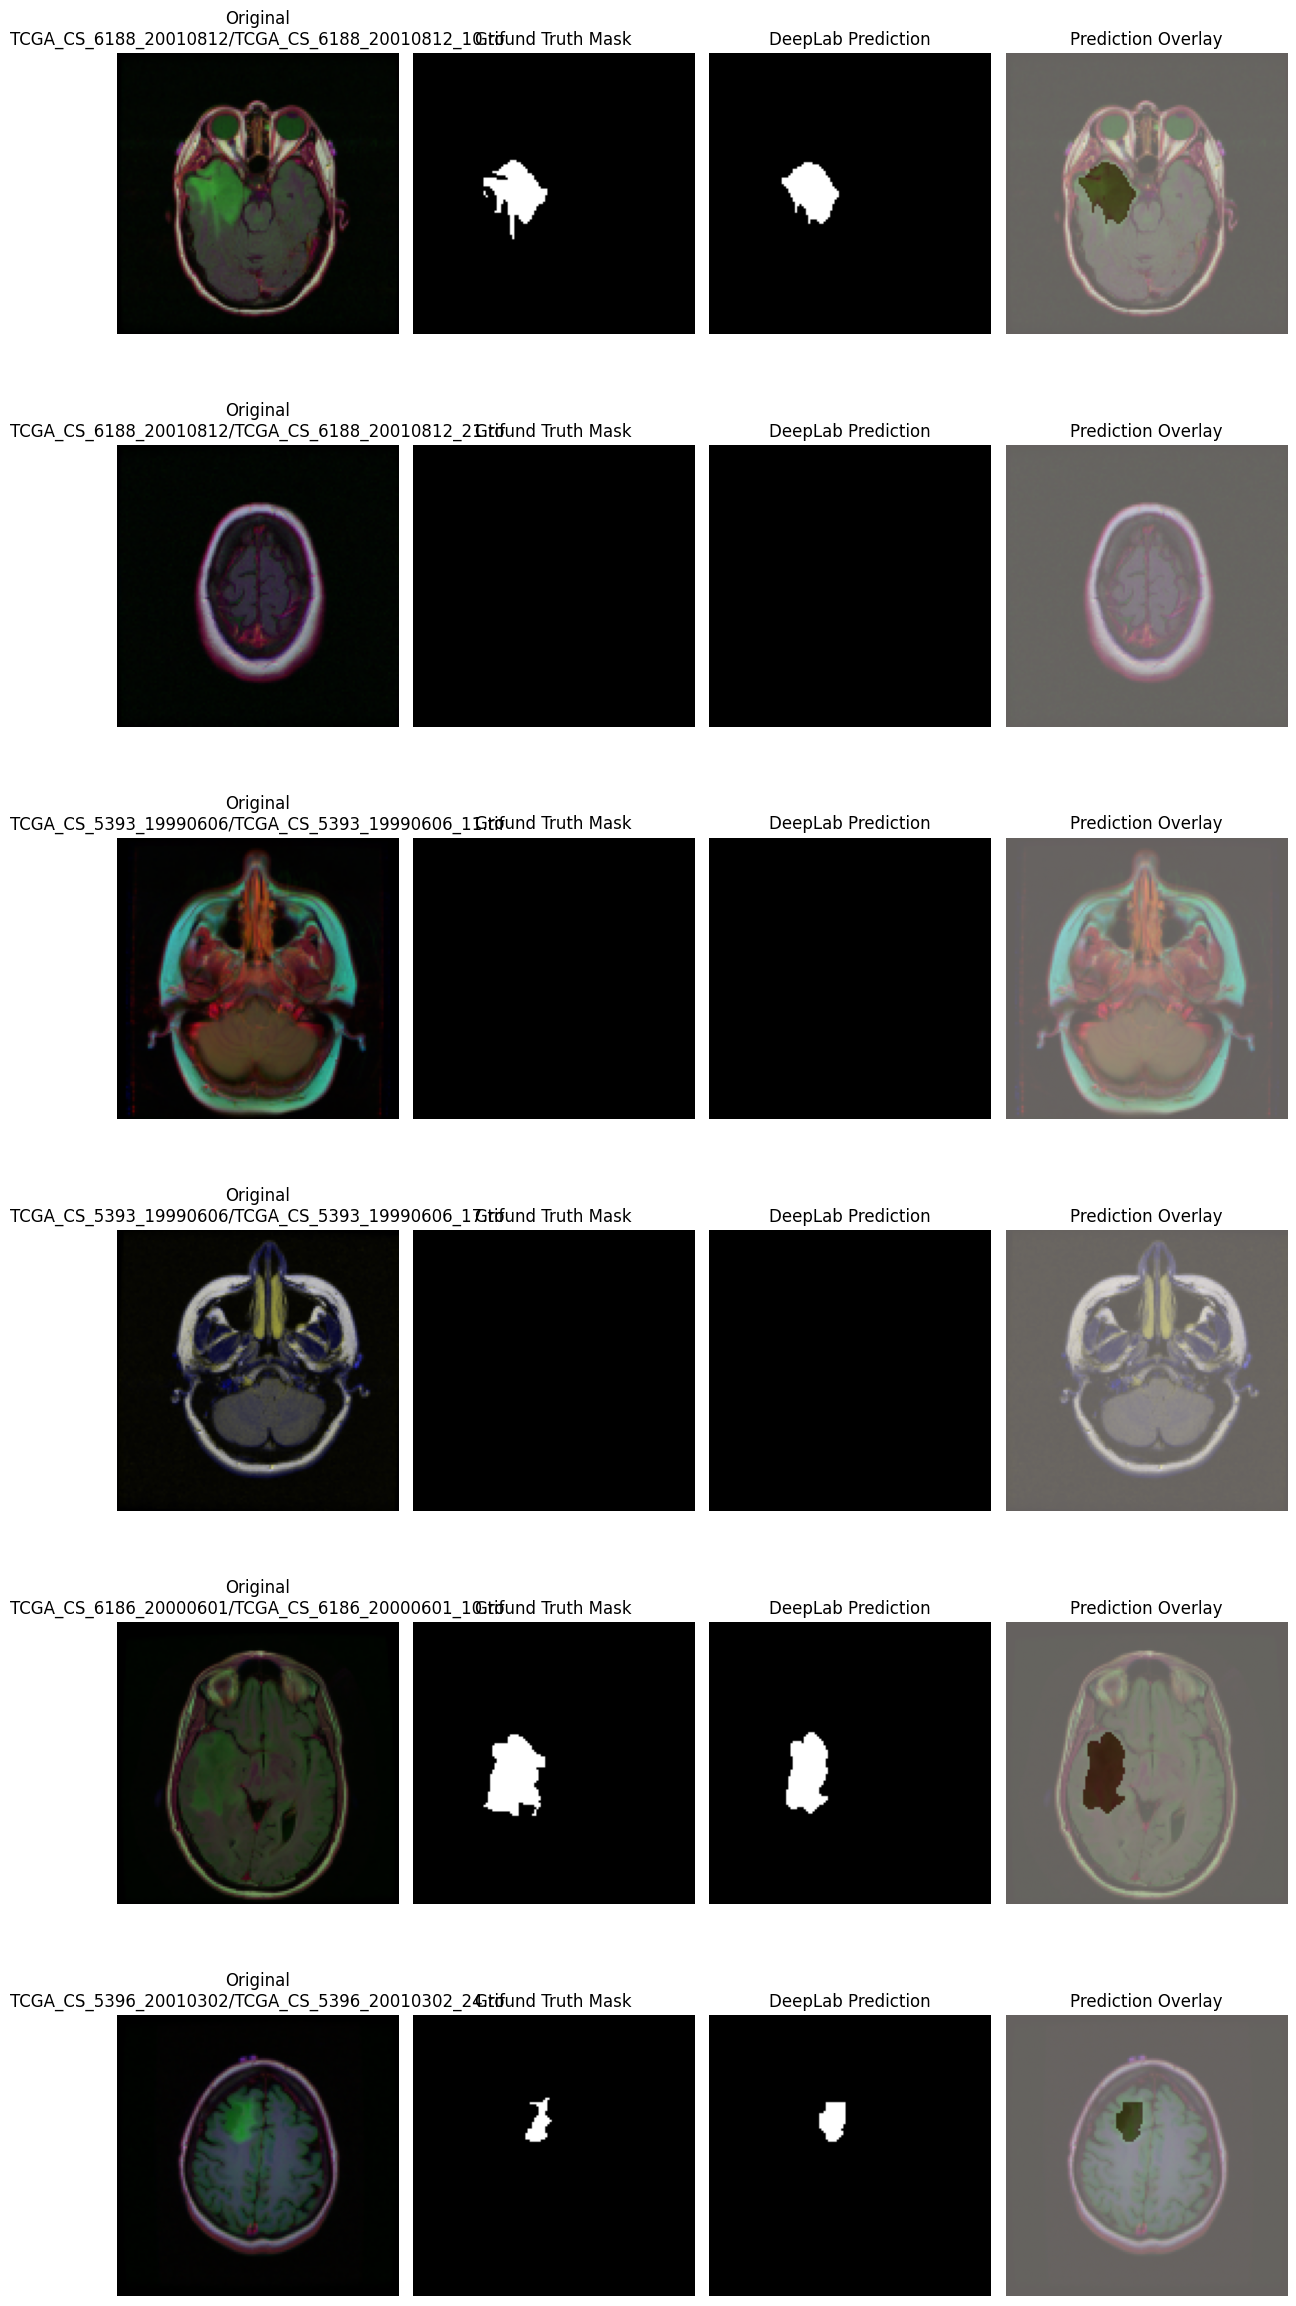

In [38]:
visualize_predictions(DeepLab, X_test, y_test, filenames, num_samples=6, model_name="DeepLab")


